<a href="https://colab.research.google.com/github/Nytilde/Edda-MLDifficultyPredictor/blob/main/MLDifficultyPredictorII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLDifficultyPredictor II
## Introduction
The aim of this jupyter notebook is to use exploratory data analysis (EDA) to optimize the existing features of the first difficulty prediction Model by PKBeam and to identify additional features. By conducting an EDA, the underlying patterns, trends and correlations in the data are to be discovered in order to create a sound basis for improving the existing features and to identify potentially relevant new features.

The goal is to increase the quality of the model through optimized feature selection and construction, leading to improved predictions and a better understanding of the underlying data.

## Setup
To run this notebook, click on the "Run with Colab" icon to import this exported environment to Google Colab and execute it in real-time.

To utilize the external libraries required for exporting ONNX and PMML files, it is recommended to host the runtime locally via a Docker instance. For a more detailed description, please refer to the following link: https://research.google.com/colaboratory/local-runtimes.html

Alternatively, you can also utilize other common Jupyter runtime environments for execution.

## ToDo
 - [x] rework of get_max_time() to determine the range between first and last time instead


 - [x] Calculate vector of time difference Δt (change rate)
  - [x] the average time difference
  - [x] longest break (maybe linear dependency)
  - [x] double notes (change rate = 0)
  - [x] longest low time periode
  - [x] inspect quantil range
  - [ ] amount of breaks within a time window (rolling window with Δt max)
  - [ ] any ideas?


 - [x] NoteDensity with Δt > 1 (rolling window)
  - [ ] inspect quantil range
  - [ ] inspect window size


 - [ ] Find and count "hard to play patterns":
  - [ ] define and match pattern by using a frequence (e.g. 1, 2, 3, 4, 3, 2, 1)
  - [ ] always check if it is a double note (if time is equal)
  - [ ] define a weight to each pattern
  - [ ] add a threshold value for the time difference between each note within the pattern
  - [ ] count each weight
  (if there is no use here, maybe we can add this also to EDDA)



# Import

In [12]:
import pandas as pd
import numpy as np
import pandas as pd
import json
import os
import csv
import random
import seaborn as sns
import scipy.stats as stats
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVR, SVC
from collections import Counter

original Methods from PKBeam

In [13]:
def getMapDataForPath(path):
    mapDataName = ""
    if "info.dat" in os.listdir(f"{path}"):
        mapDataName = "info.dat"
    if "Info.dat" in os.listdir(f"{path}"):
        mapDataName = "Info.dat"
    with open(f"{path}/{mapDataName}", "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getMapData(mapFolder, folder):
    return getMapDataForPath(f"{mapFolder}/{folder}")

def getDifficultyMapsForPath(path):
    difficultyMaps = []
    mapJson = getMapDataForPath(path)
    for d in mapJson["_difficultyBeatmapSets"][0]["_difficultyBeatmaps"]:
        difficultyMaps.append((d["_beatmapFilename"], d["_difficultyRank"]))
    return difficultyMaps

def getDifficultyMaps(mapFolder, folder):
    return getDifficultyMapsForPath(f"{mapFolder}/{folder}")

def getDifficultyMapDataForPath(path, file):
    filePath = f"{path}/{file}"
    with open(filePath, "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getDifficultyMapData(mapFolder, folder, file):
    return getDifficultyMapDataForPath(f"{mapFolder}/{folder}", file)

def getMaps(mapFolder):
    maps = []
    for obj in os.listdir(f"{mapFolder}"):
        objPath = f"{mapFolder}/{obj}"
        if os.path.isdir(objPath) and ("info.dat" in os.listdir(objPath) or "Info.dat" in os.listdir(objPath)):
            maps.append(obj)
    return maps

def beatToSec(beat, bpm):
    return 60/bpm * beat

# def getNoteDensity(diffMapData, duration):
#     notesList = diffMapData["_notes"]
#     return len(notesList)/duration

# # heuristically, windowLength = 2.75, step = 0.25 is best  // replaced by numpy version
# def getLocalNoteDensities(time_array, duration, windowLength=2.75, step=0.25):
#     densities = []
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         numNotes = 0
#         for noteTime in time_array:
#             if windowLower <= noteTime and noteTime <= windowUpper:
#                 numNotes += 1
#         densities.append(numNotes/windowLength)
#         windowLower += step
#         windowUpper += step
#     return densities

# def getLocalColumnVariety(diffMapData, duration, bpm, windowLength=2.75, step=0.25):
#     variety = []
#     beatsPerWindow = bpm/60 * windowLength
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         localVariety = np.array([0, 0, 0, 0])
#         for n in diffMapData["_notes"]:
#             noteTime = beatToSec(n["_time"], bpm)
#             noteCol = n["_lineIndex"]
#             if windowUpper <= noteTime:
#                 break
#             if windowLower <= noteTime:
#                 localVariety[noteCol] += 1
#             if np.linalg.norm(localVariety, 1) > 0:
#                 # L1-normalise or normalise for the amount of notes
#                 normLocalVariety = localVariety / np.linalg.norm(localVariety, 1)
#                 # maps with higher column variety will have a distribution closer to [.25, .25, .25, .25]
#                 score = np.linalg.norm(normLocalVariety - np.array([0.25, 0.25, 0.25, 0.25]), 2)
#                 # higher is better
#                 variety.append(-1 * score)

#         windowLower += step
#         windowUpper += step
#     return variety

In [14]:
# use numpy and vectorized processing instead of loop
def get_note_density_per_window(time_array, time_diff, window_length=2.75):
    cumulative_time = np.cumsum(time_diff)

    start_times = time_array - window_length

    start_indices = np.searchsorted(cumulative_time, start_times, side='left')
    end_indices = np.searchsorted(cumulative_time, time_array, side='left')

    return (end_indices - start_indices) / window_length

def get_note_density(float_array, duration):
    return len(float_array)/duration

def extract_times_from_dicts_list(dicts_list, bpm, key='_time'):
    return np.array([beatToSec(d['_time'], bpm) for d in dicts_list])

def get_min_max_diff(float_array):
    return max(float_array) - min(float_array)

def remove_zeros(float_array, tolerance=1e-4):
    non_zero_indices = np.abs(float_array) > tolerance
    return float_array[non_zero_indices]

def get_longest_low_value_sequence(time_diffs):
    unique_values, indices, counts = np.unique(time_diffs, return_index=True, return_counts=True)
    matrix = np.zeros((len(unique_values), len(time_diffs)), dtype=int)

    for idx, count in zip(indices, counts):
        val_index = np.where(unique_values == time_diffs[idx])[0][0]
        matrix[val_index, idx:idx+count] = 1

    row_sums = np.sum(matrix, axis=1)
    max_density_index = np.argmax(row_sums / len(time_diffs))
    max_density = row_sums[max_density_index] / len(time_diffs)

    series_start = np.argmax(matrix[max_density_index])
    series_end = np.argmax(np.flip(matrix[max_density_index]))

    return time_diffs[series_start:series_end+1]

def generate_leave_one_value_out_sequence(lst):
    for i, value in enumerate(lst):
         yield (lst[:i] + lst[i+1:], value)

def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))

def max_abs_column_name(row):
    return row.abs().idxmax()

def min_abs_column_name(row):
    return row.abs().idxmin()

def second_max_abs_column_name(row):
    return row.abs().sort_values(ascending=False).index[1]

def plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap=cmap)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)

    plt.show()

# Upload / Import Raw Data



you can upload a zip folder with the maps and unzip it with the following script

In [ ]:
# uploaded
import zipfile

def unzip_file(path, extract_to):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    extracted_files = os.listdir(extract_to)

unzip_file("RagnarockMaps.zip",'./')

MAP_FOLDER = '/RagnarockMaps/RagnarockMaps'

# for root, dirs, files in os.walk(MAP_FOLDER):
#     for file in files:
#         file_path = os.path.join(root, file)
#         print(file_path)

or upload the data to google drive and enter the link below. the home folder is located in `content/drive/My Drive/`.

(remember to authorise access)

In [6]:
# Google Drive
MAP_FOLDER = '/content/drive/My Drive/ragna/RagnarockMaps'

if further access authorisations are required, these can be requested here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preparations

In [7]:
def transform_data(target_feature):
    for beatmap in getMaps(MAP_FOLDER):
        mapData = getMapData(MAP_FOLDER, beatmap)
        songName = mapData["_songName"]
        songDuration = mapData["_songApproximativeDuration"]
        songBpm = mapData["_beatsPerMinute"]

        diffMaps = getDifficultyMaps(MAP_FOLDER, beatmap)
        for diffMapObj in diffMaps:
            diffMap = diffMapObj[0]
            diffRank = diffMapObj[1]

            # don't train on maps with >10 rank
            if (diffRank > 10):
                print(f"diff rank > 10 excluded: '{songName}'")
                continue

            diffMapData = getDifficultyMapData(MAP_FOLDER, beatmap, diffMap)

            time_series = extract_times_from_dicts_list(diffMapData['_notes'], songBpm, key='_time')
            time_differences = np.diff(time_series)
            time_differences_no_zero = remove_zeros(time_differences)
            max_time = get_min_max_diff(time_series)

            diffMapNoteDensity = get_note_density(time_series, max_time)

            # diffMapLND2s = getLocalNoteDensities(diffMapData, max_time, songBpm, windowLength=2.75)
            diffMapLND2s = get_note_density_per_window(time_series, time_differences_no_zero, window_length=2.75)
            maxND2s = np.quantile(diffMapLND2s, 0.95)
            diffMapLND8s = get_note_density_per_window(time_series, time_differences_no_zero, window_length=8)

            average_time_diff = np.mean(time_differences_no_zero)
            longest_break = max(time_differences)
            double_notes = np.sum(time_differences == 0)

            longest_high_density_sequence = get_longest_low_value_sequence(time_differences_no_zero)

            auc = np.trapz(time_series, range(len(time_series)))

            average_2s_density = np.mean(diffMapLND2s)
            average_8s_density = np.mean(diffMapLND8s)

            yield {
                "SongName": songName,
                "BPM": songBpm,
                "NoteDensity": diffMapNoteDensity,
                "HighNoteDensity2s": maxND2s,
                "AverageTimeDifference": average_time_diff,
                "LongestBreak": longest_break,
                "DoubleNotes": double_notes,
                "LongestHighDensitySequence": longest_high_density_sequence,
                "auc": auc,
                "TimeDifferences": time_differences_no_zero,
                "Notes": time_series,
                "DiffMapLND2s": diffMapLND2s,
                "diffMapLND8s": diffMapLND8s,
                "Average2sDensity": average_2s_density,
                "Average8sDensity": average_8s_density,
                target_feature: diffRank
            }

targetFeature = ["Difficulty"]

df = pd.DataFrame(transform_data(targetFeature[0]))

In [8]:
# change rate
for i in range(9):
  j = (i+1)/10
  df[f"d1Q{j}"] = df["TimeDifferences"].apply(lambda x: np.quantile(x, j))
  df[f"d8Q{j}"] = df["diffMapLND8s"].apply(lambda x: np.quantile(x, j))
  df[f"d2.75Q{j}"] = df["DiffMapLND2s"].apply(lambda x: np.quantile(x, j))
df["d1Q0.1"]

0      0.234375
1      0.117188
2      0.117188
3      0.238095
4      0.119048
         ...   
235    0.236220
236    0.118110
237    0.375000
238    0.187500
239    0.093750
Name: d1Q0.1, Length: 240, dtype: float64

In [9]:
# generate extra features afterwards
df["d1max"] = df["TimeDifferences"].apply(lambda x: np.max(x))
df["d8max"] = df["diffMapLND8s"].apply(lambda x: np.max(x))
df["d2.75max"] = df["DiffMapLND2s"].apply(lambda x: np.max(x))

df["d1min"] = df["TimeDifferences"].apply(lambda x: np.min(remove_zeros(x)))
df["d8min"] = df["diffMapLND8s"].apply(lambda x: np.min(remove_zeros(x)))
df["d2.75min"] = df["DiffMapLND2s"].apply(lambda x: np.min(remove_zeros(x)))

df["d1mad"] = df["TimeDifferences"].apply(lambda x: mean_absolute_deviation(x))
df["d8mad"] = df["diffMapLND8s"].apply(lambda x: mean_absolute_deviation(x))
df["d2.75mad"] = df["DiffMapLND2s"].apply(lambda x: mean_absolute_deviation(x))

df["d1std"] = df["TimeDifferences"].apply(lambda x: np.std(x))
df["d8std"] = df["diffMapLND8s"].apply(lambda x: np.std(x))
df["d2.75std"] = df["DiffMapLND2s"].apply(lambda x: np.std(x))

df["d8mean"] = df["diffMapLND8s"].apply(lambda x: np.mean(x))
df["d2.75mean"] = df["DiffMapLND2s"].apply(lambda x: np.mean(x))

df["LongestHighDensitySequenceLen"] = df["LongestHighDensitySequence"].apply(lambda x: len(x))
df["LongestHighDensitySequenceAverage"] = df["LongestHighDensitySequence"].apply(lambda x: np.average(x)).fillna(0.0)


df["ammountNotes"] = df["Notes"].apply(lambda x: len(x))
df["aucRel"] = df.apply(lambda row: row["auc"] / row["ammountNotes"], axis=1)
df["BPMxN"] = df.apply(lambda row: (row["ammountNotes"] - row["DoubleNotes"]) * row["BPM"], axis=1)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


# Features
select all relevant generated features

In [10]:
def exclude_elements(input_list, excluded_elements):
    return [x for x in input_list if x not in set(excluded_elements)]

featureList = exclude_elements(df.columns.to_list(), [*targetFeature, "TimeDifferences", "Notes", "DiffMapLND2s", "diffMapLND8s", 'SongName', 'LongestHighDensitySequence'])
X = df[featureList]
y = df[targetFeature]
print(featureList)
print(len(featureList))

['BPM', 'NoteDensity', 'HighNoteDensity2s', 'AverageTimeDifference', 'LongestBreak', 'DoubleNotes', 'auc', 'Average2sDensity', 'Average8sDensity', 'd1Q0.1', 'd8Q0.1', 'd2.75Q0.1', 'd1Q0.2', 'd8Q0.2', 'd2.75Q0.2', 'd1Q0.3', 'd8Q0.3', 'd2.75Q0.3', 'd1Q0.4', 'd8Q0.4', 'd2.75Q0.4', 'd1Q0.5', 'd8Q0.5', 'd2.75Q0.5', 'd1Q0.6', 'd8Q0.6', 'd2.75Q0.6', 'd1Q0.7', 'd8Q0.7', 'd2.75Q0.7', 'd1Q0.8', 'd8Q0.8', 'd2.75Q0.8', 'd1Q0.9', 'd8Q0.9', 'd2.75Q0.9', 'd1max', 'd8max', 'd2.75max', 'd1min', 'd8min', 'd2.75min', 'd1mad', 'd8mad', 'd2.75mad', 'd1std', 'd8std', 'd2.75std', 'd8mean', 'd2.75mean', 'LongestHighDensitySequenceLen', 'LongestHighDensitySequenceAverage', 'ammountNotes', 'aucRel', 'BPMxN']
55


For testing, it's easier to define a selection individually.

In [11]:
x_test_dims = ["NoteDensity", "AverageTimeDifference", "LongestHighDensitySequenceLen", "HighNoteDensity2s"]

# Visualization

## descriptive

In [ ]:
df.describe()

BPM  NoteDensity  HighNoteDensity2s  AverageTimeDifference  \
count  240.000000   240.000000         240.000000             240.000000   
mean   150.812500     4.378120           5.805833               0.312750   
std     32.550608     1.297783           2.114966               0.119412   
min     60.000000     1.627074           2.181818               0.152743   
25%    128.000000     3.286362           4.195455               0.222472   
50%    149.000000     4.270664           5.636364               0.287035   
75%    174.250000     5.360652           7.272727               0.387574   
max    244.000000     7.615101          12.363636               0.793388   

       LongestBreak  DoubleNotes           auc  Average2sDensity  \
count    240.000000   240.000000  2.400000e+02        240.000000   
mean       3.688310   166.729167  1.307730e+05          3.873541   
std        3.236181    88.172411  1.179285e+05          1.322264   
min        0.625000     1.000000  1.078299e+04          1.348351   
25%        1.736779   101.750000  6.899945e+04          2.820145   
50%        2.700000   154.000000  1.040520e+05          3.820998   
75%        4.285714   214.250000  1.507973e+05          4.897766   
max       23.435432   579.000000  1.162695e+06          7.128545   

       Average8sDensity  Difficulty  ...       d1std       d8std    d2.75std  \
count        240.000000  240.000000  ...  240.000000  240.000000  240.000000   
mean           3.773041    5.562500  ...    0.252749    1.020751    1.214697   
std            1.264198    2.482628  ...    0.129869    0.448090    0.521238   
min            1.262537    1.000000  ...    0.095571    0.277576    0.422676   
25%            2.767595    3.000000  ...    0.158821    0.678079    0.848920   
50%            3.667284    5.500000  ...    0.218737    0.959655    1.123593   
75%            4.731486    8.000000  ...    0.305347    1.280627    1.505665   
max            6.733692   10.000000  ...    0.829080    2.957577    3.309350   

           d8mean   d2.75mean  LongestHighDensitySequenceLen  \
count  240.000000  240.000000                     240.000000   
mean     3.773041    3.873541                     379.104167   
std      1.264198    1.322264                     274.623793   
min      1.262537    1.348351                       0.000000   
25%      2.767595    2.820145                     208.000000   
50%      3.667284    3.820998                     338.500000   
75%      4.731486    4.897766                     484.000000   
max      6.733692    7.128545                    2547.000000   

       LongestHighDensitySequenceAverage  ammountNotes      aucRel  \
count                         240.000000     240.00000  240.000000   
mean                            0.293710    1006.78750  118.447019   
std                             0.133143     449.62333   36.210430   
min                             0.000000     216.00000   40.435381   
25%                             0.207417     690.75000   99.424008   
50%                             0.270873     938.50000  112.134466   
75%                             0.355546    1224.75000  134.409900   
max                             0.881579    3623.00000  330.096079   

               BPMxN  
count     240.000000  
mean   128743.904167  
std     72392.992610  
min     14820.000000  
25%     77170.000000  
50%    110125.500000  
75%    163790.500000  
max    545190.000000  

[8 rows x 56 columns]

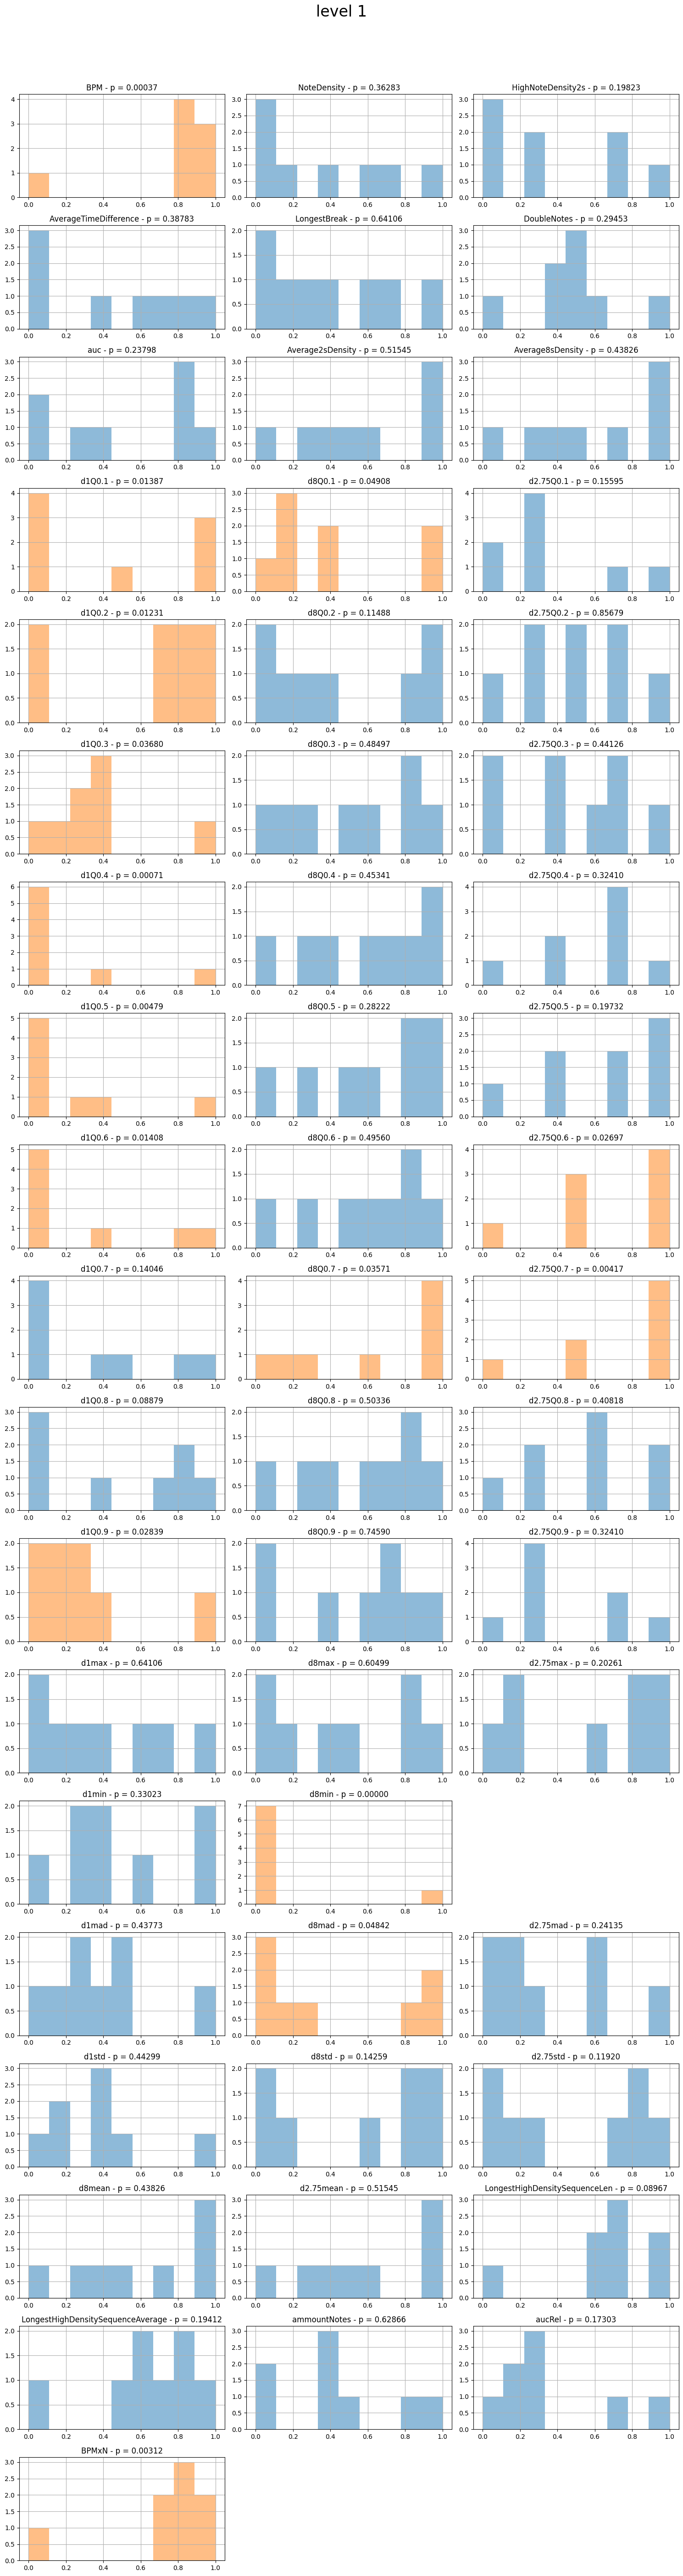

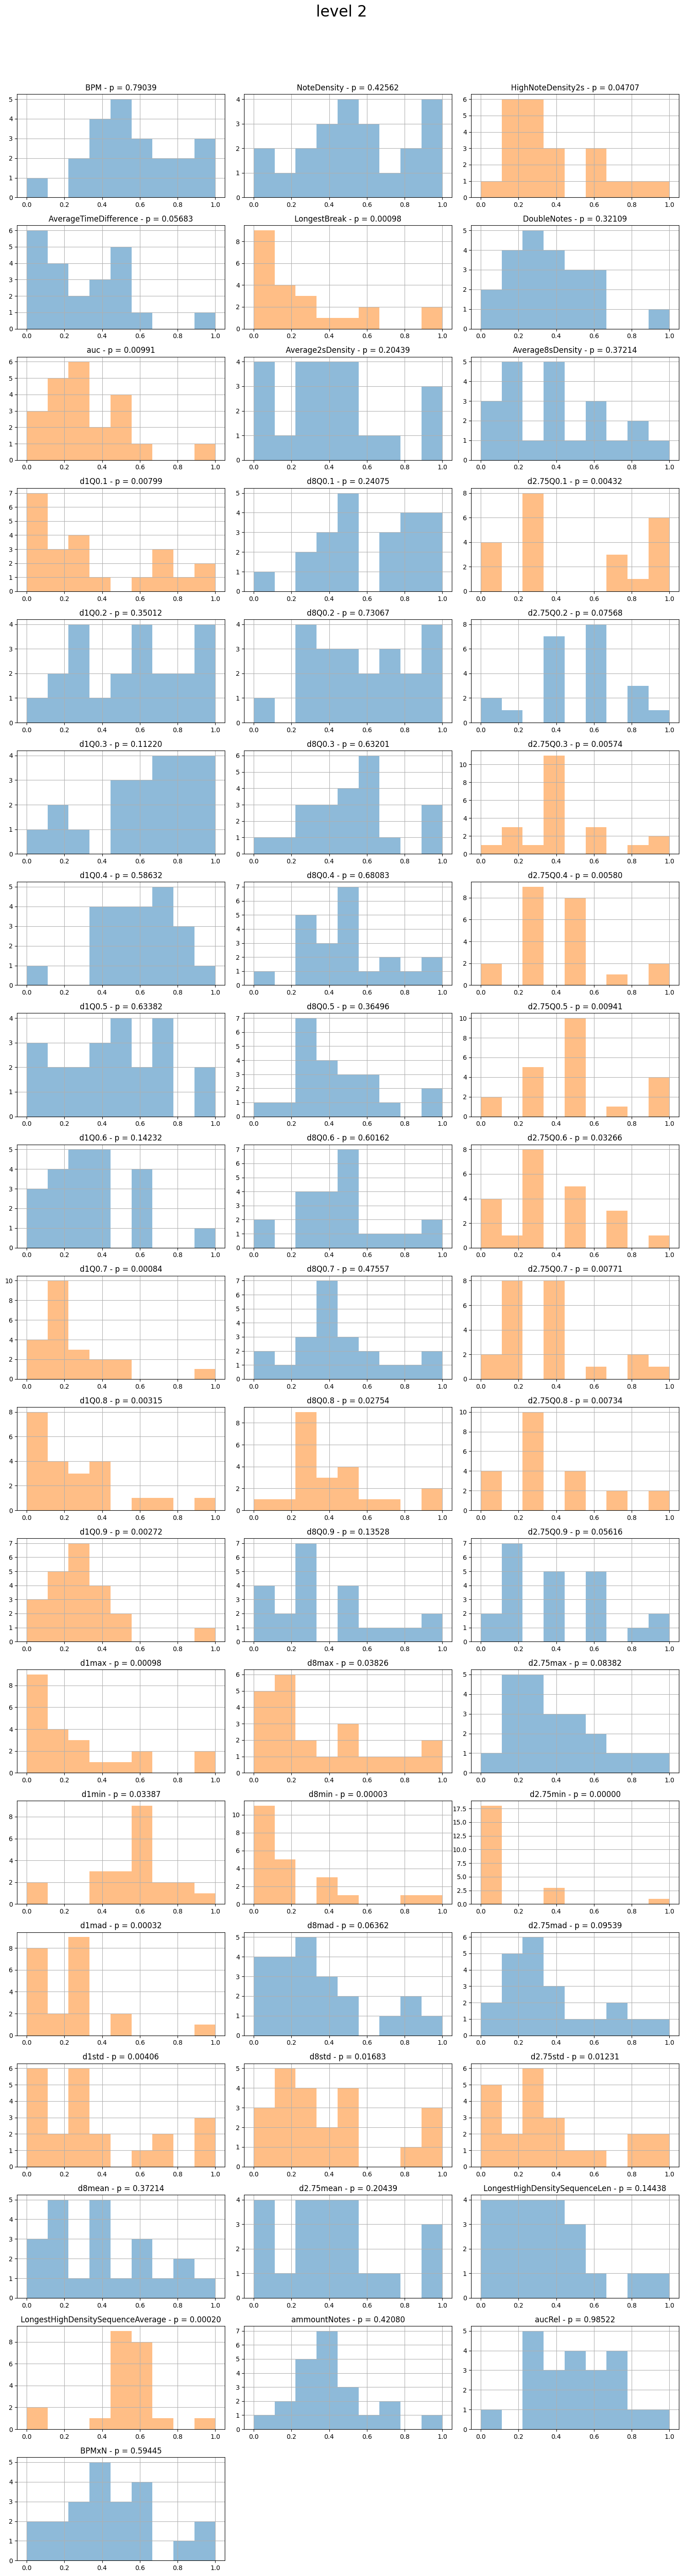

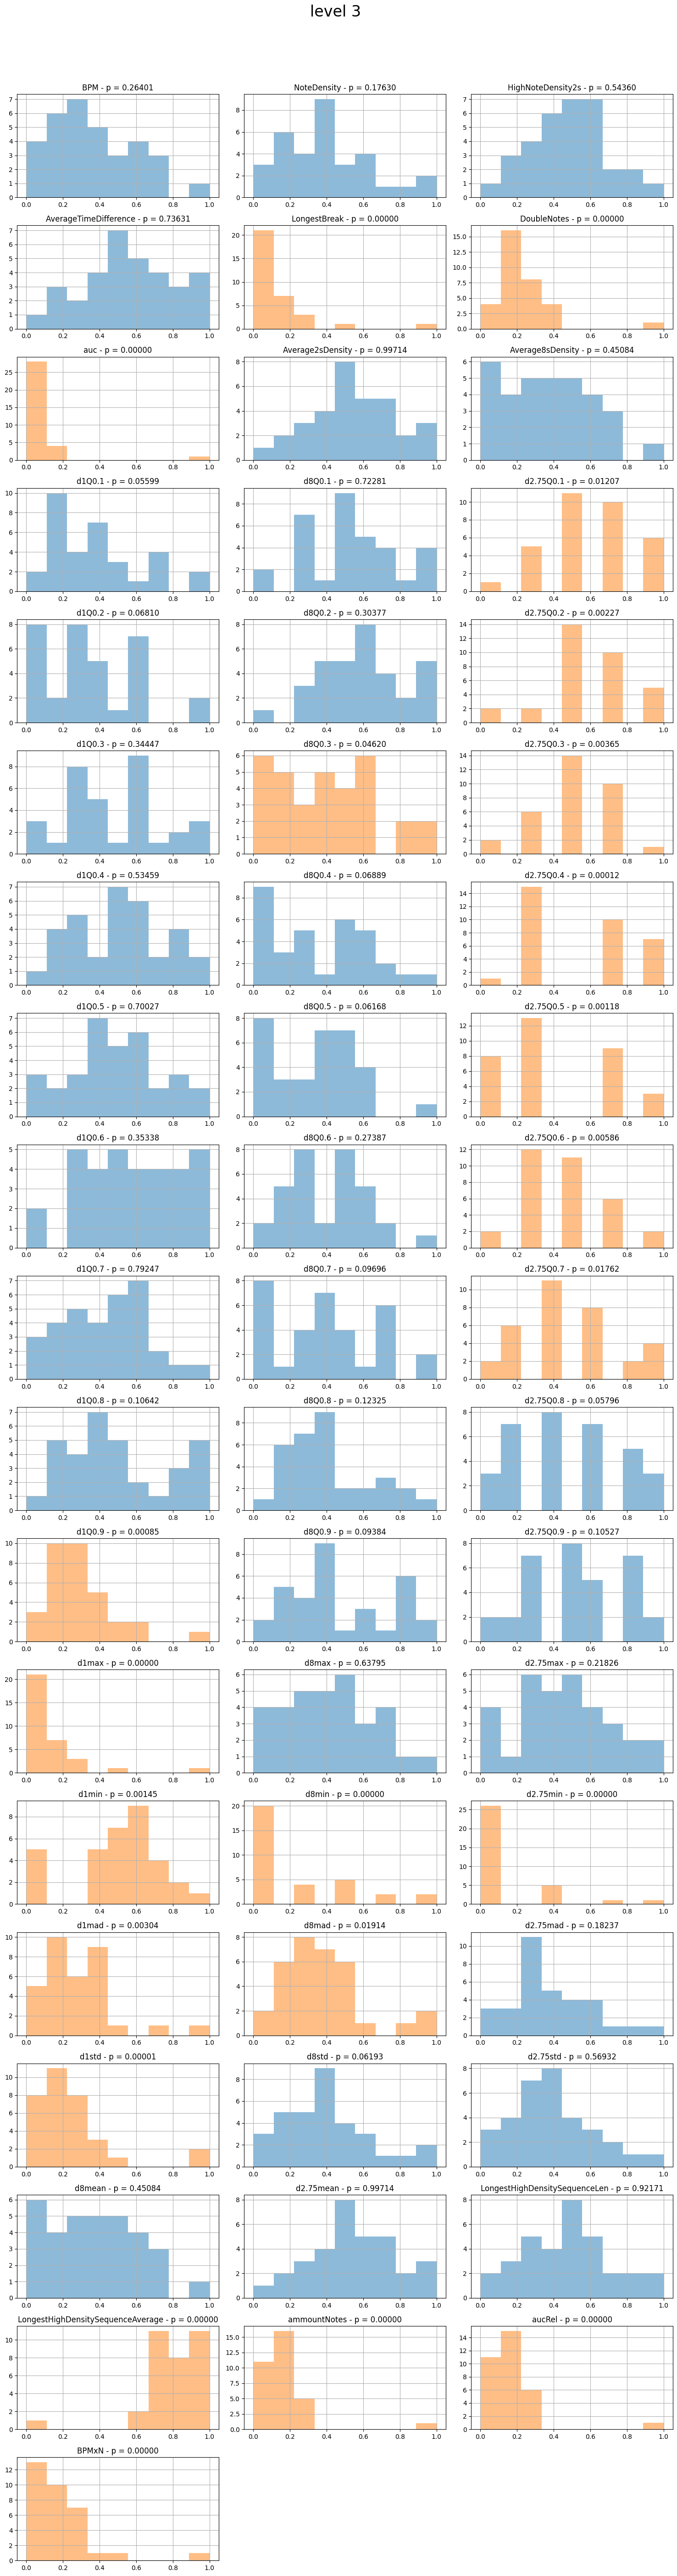

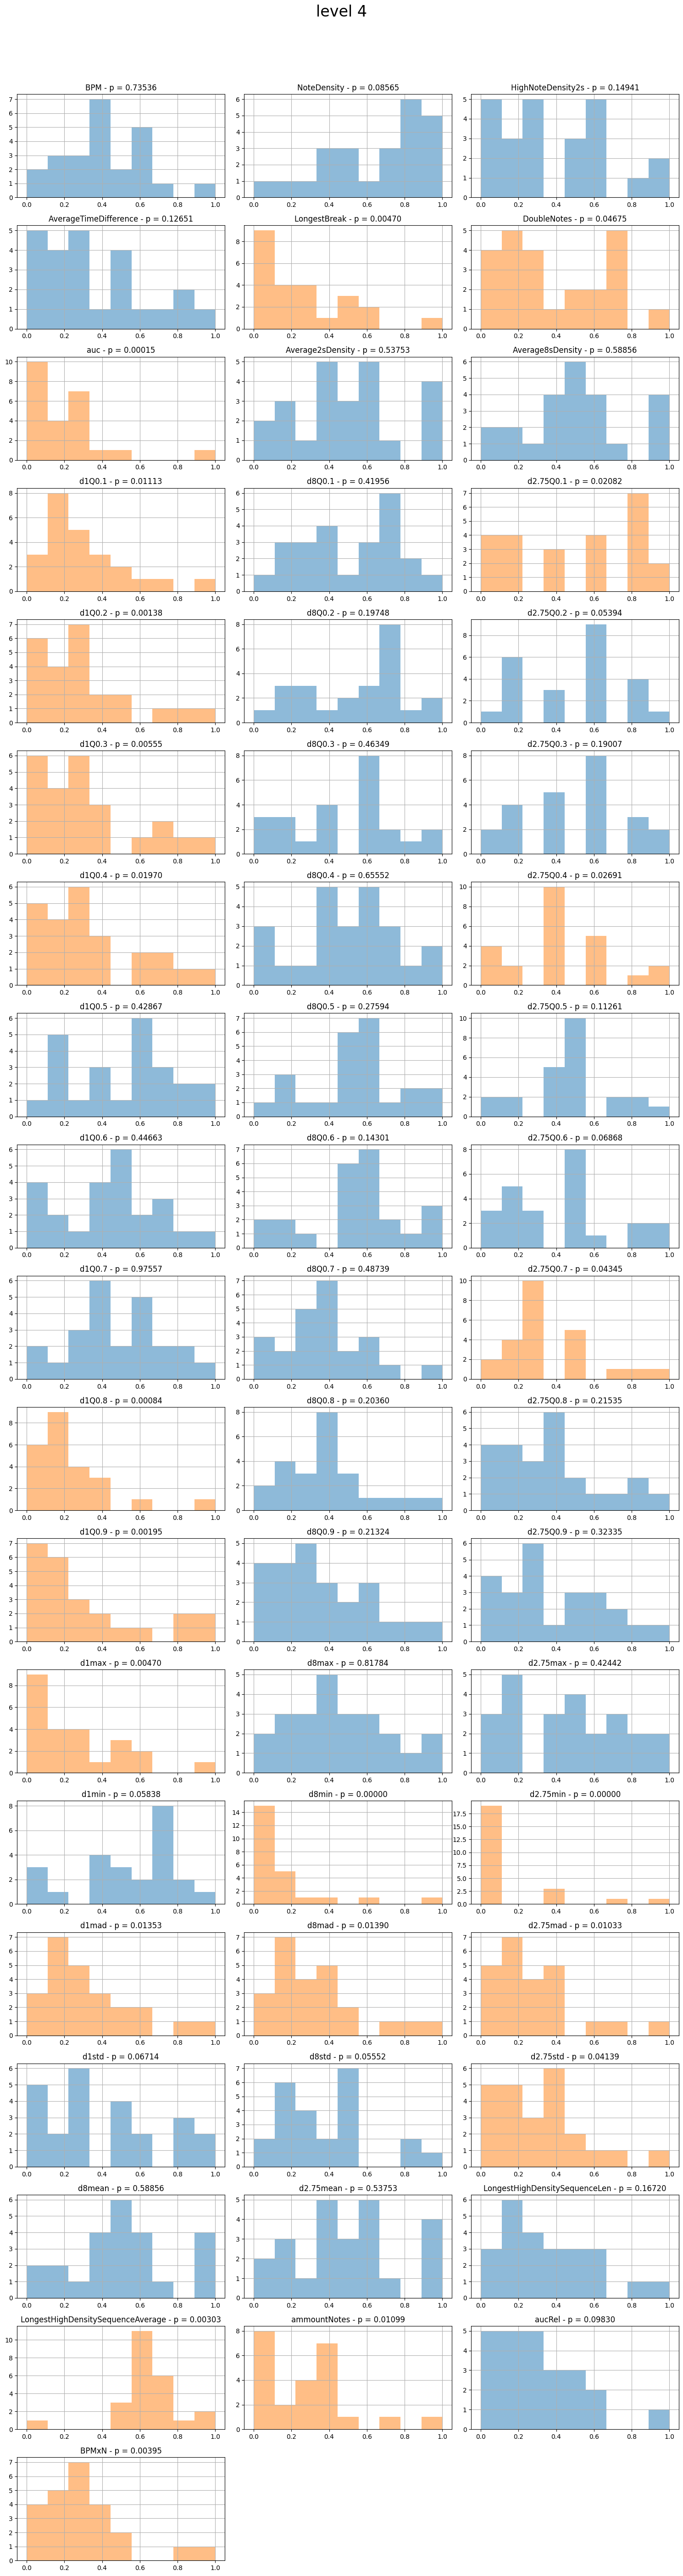

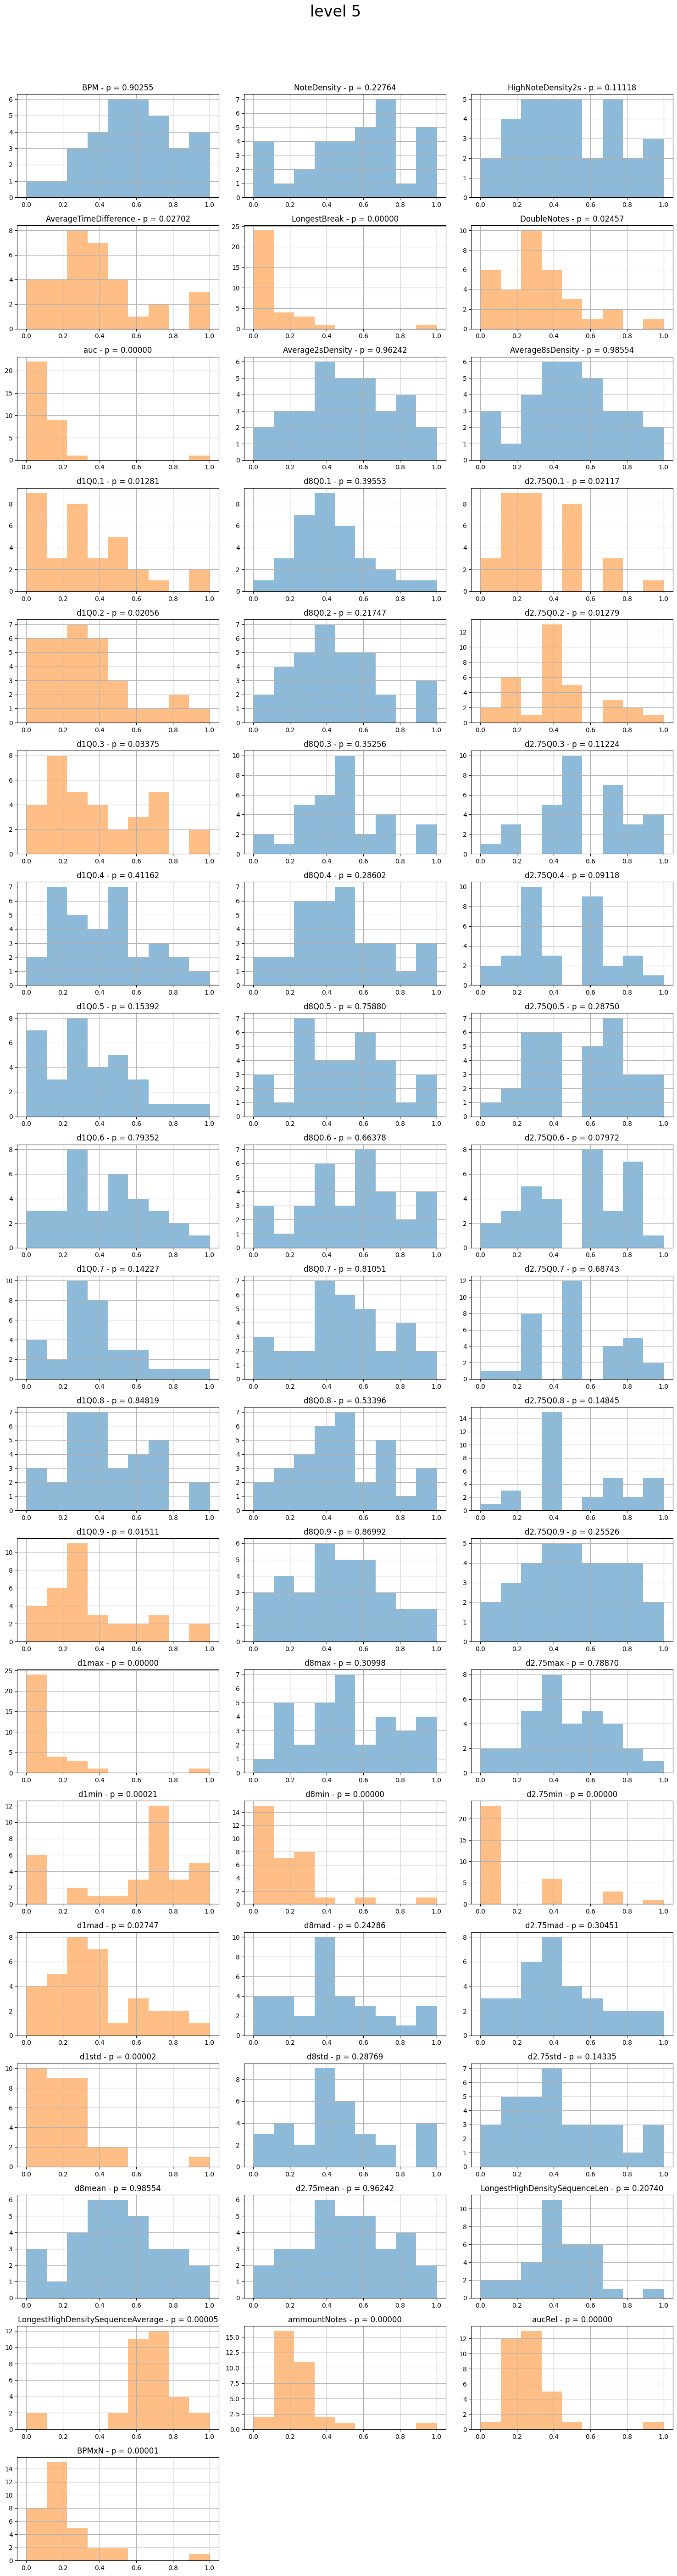

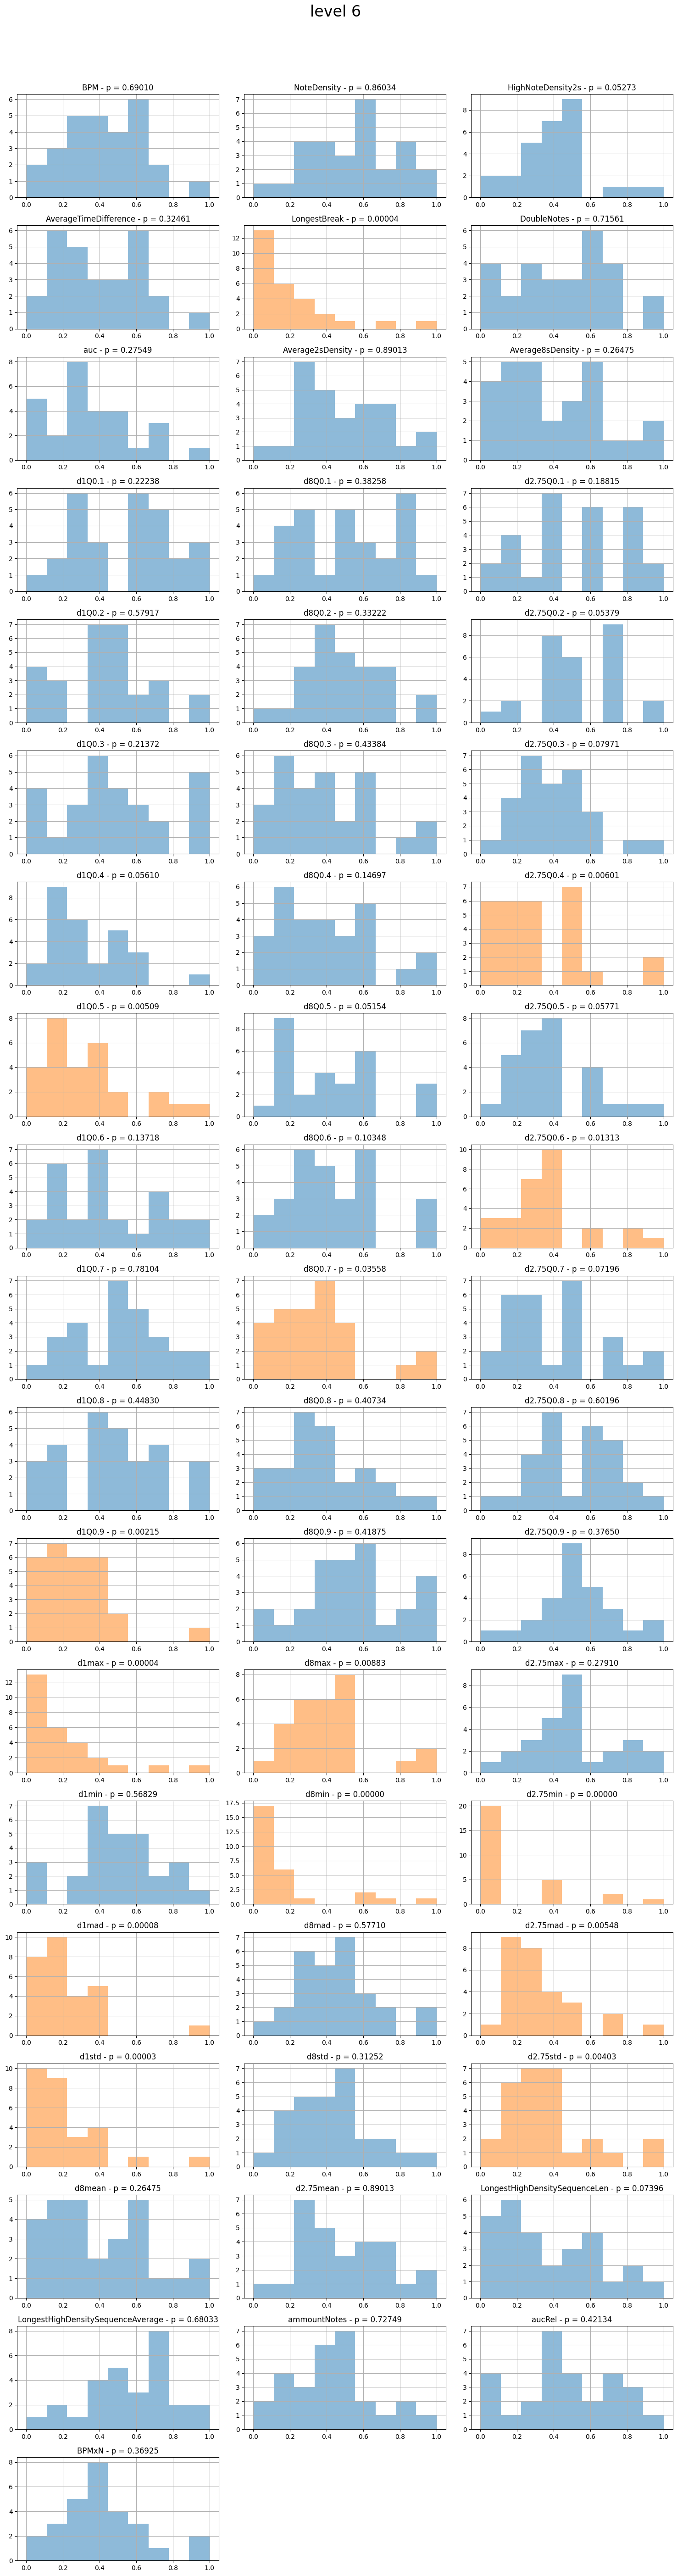

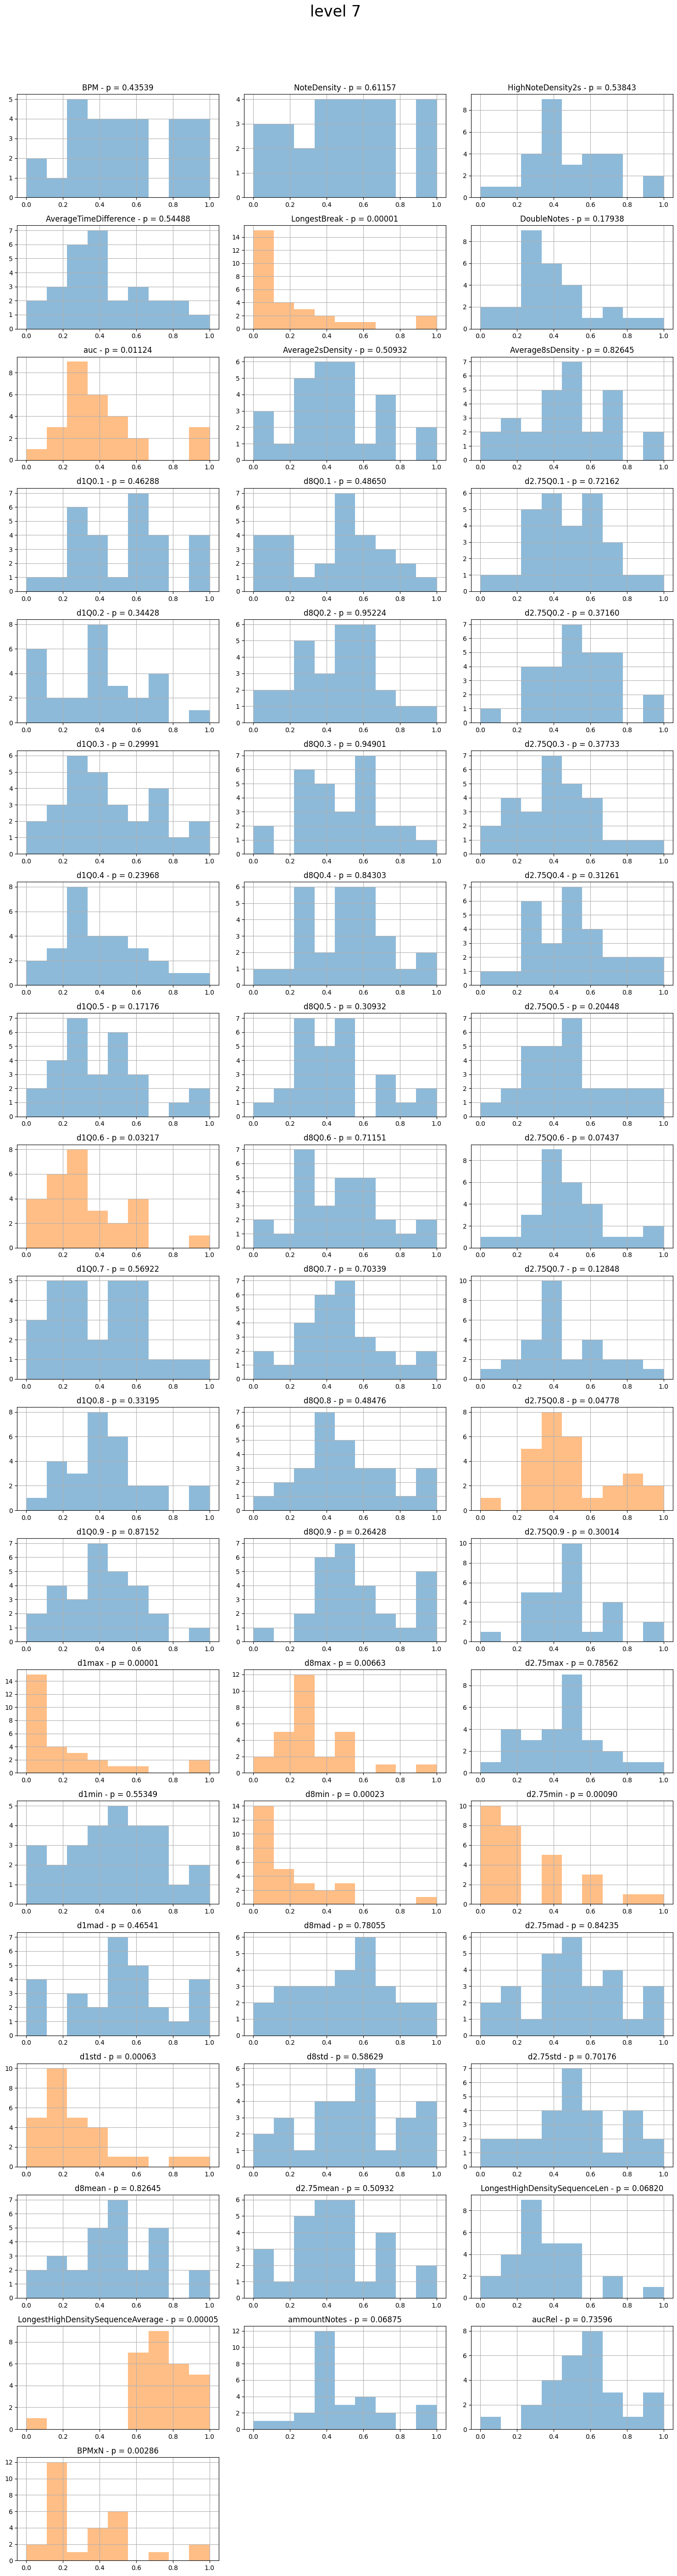

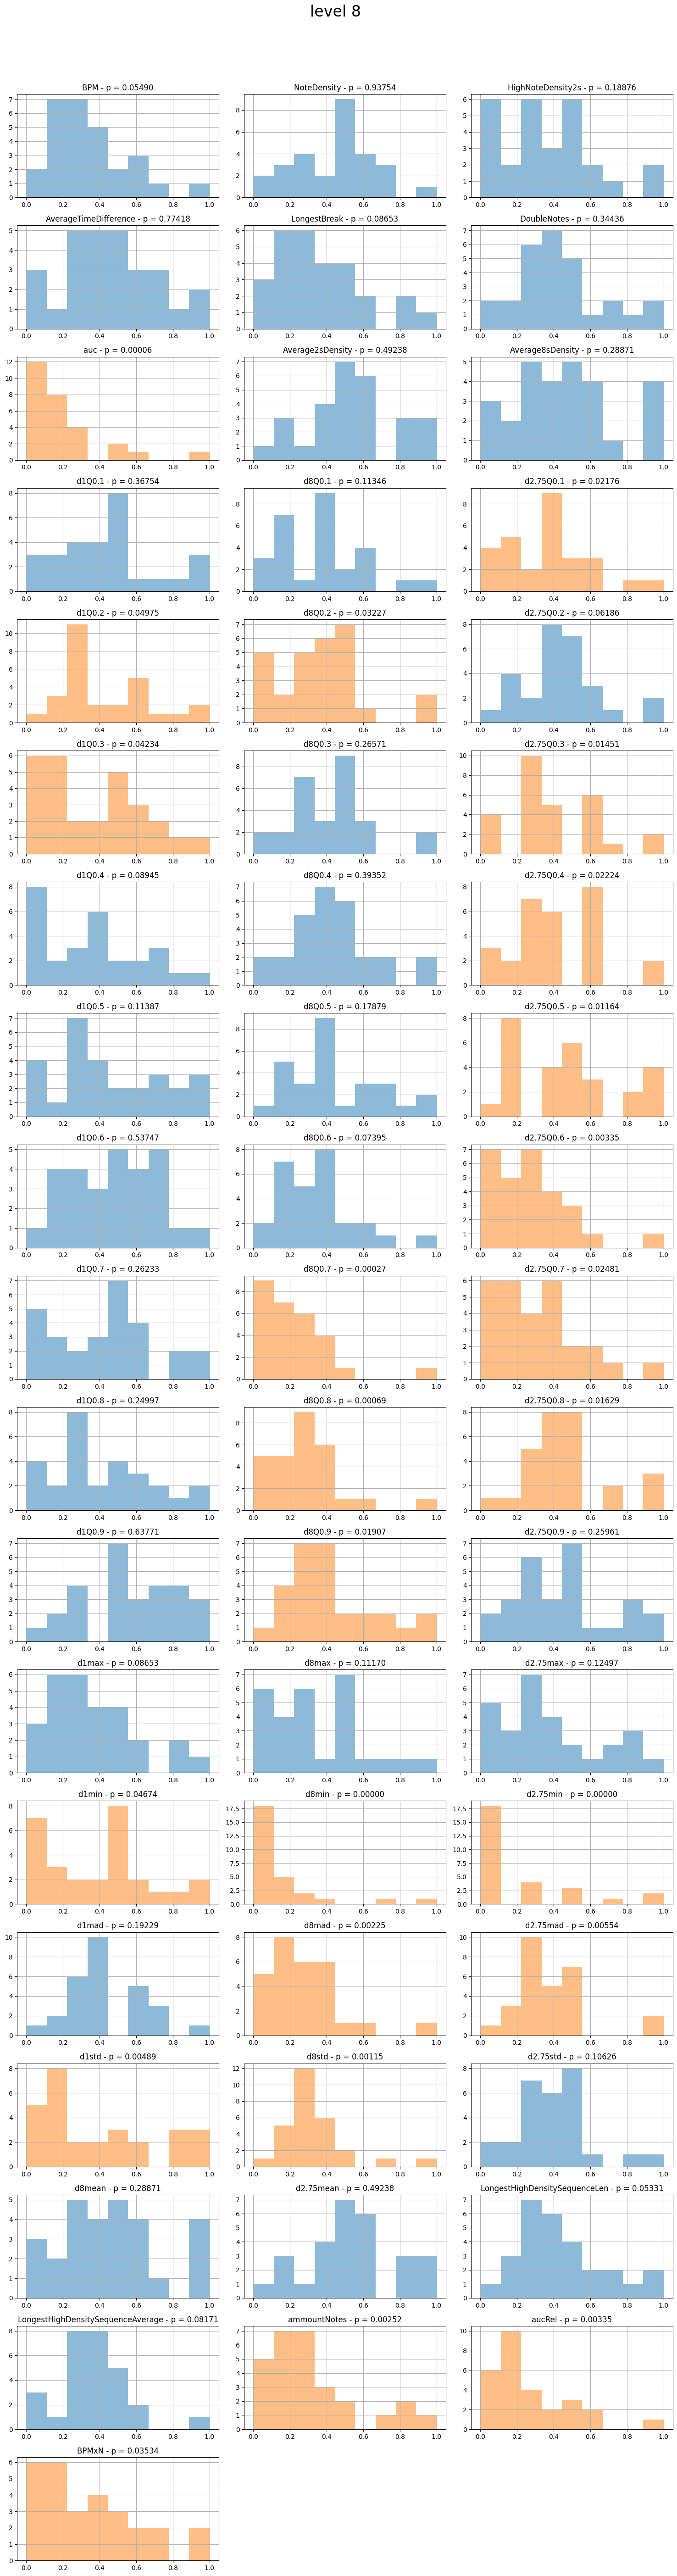

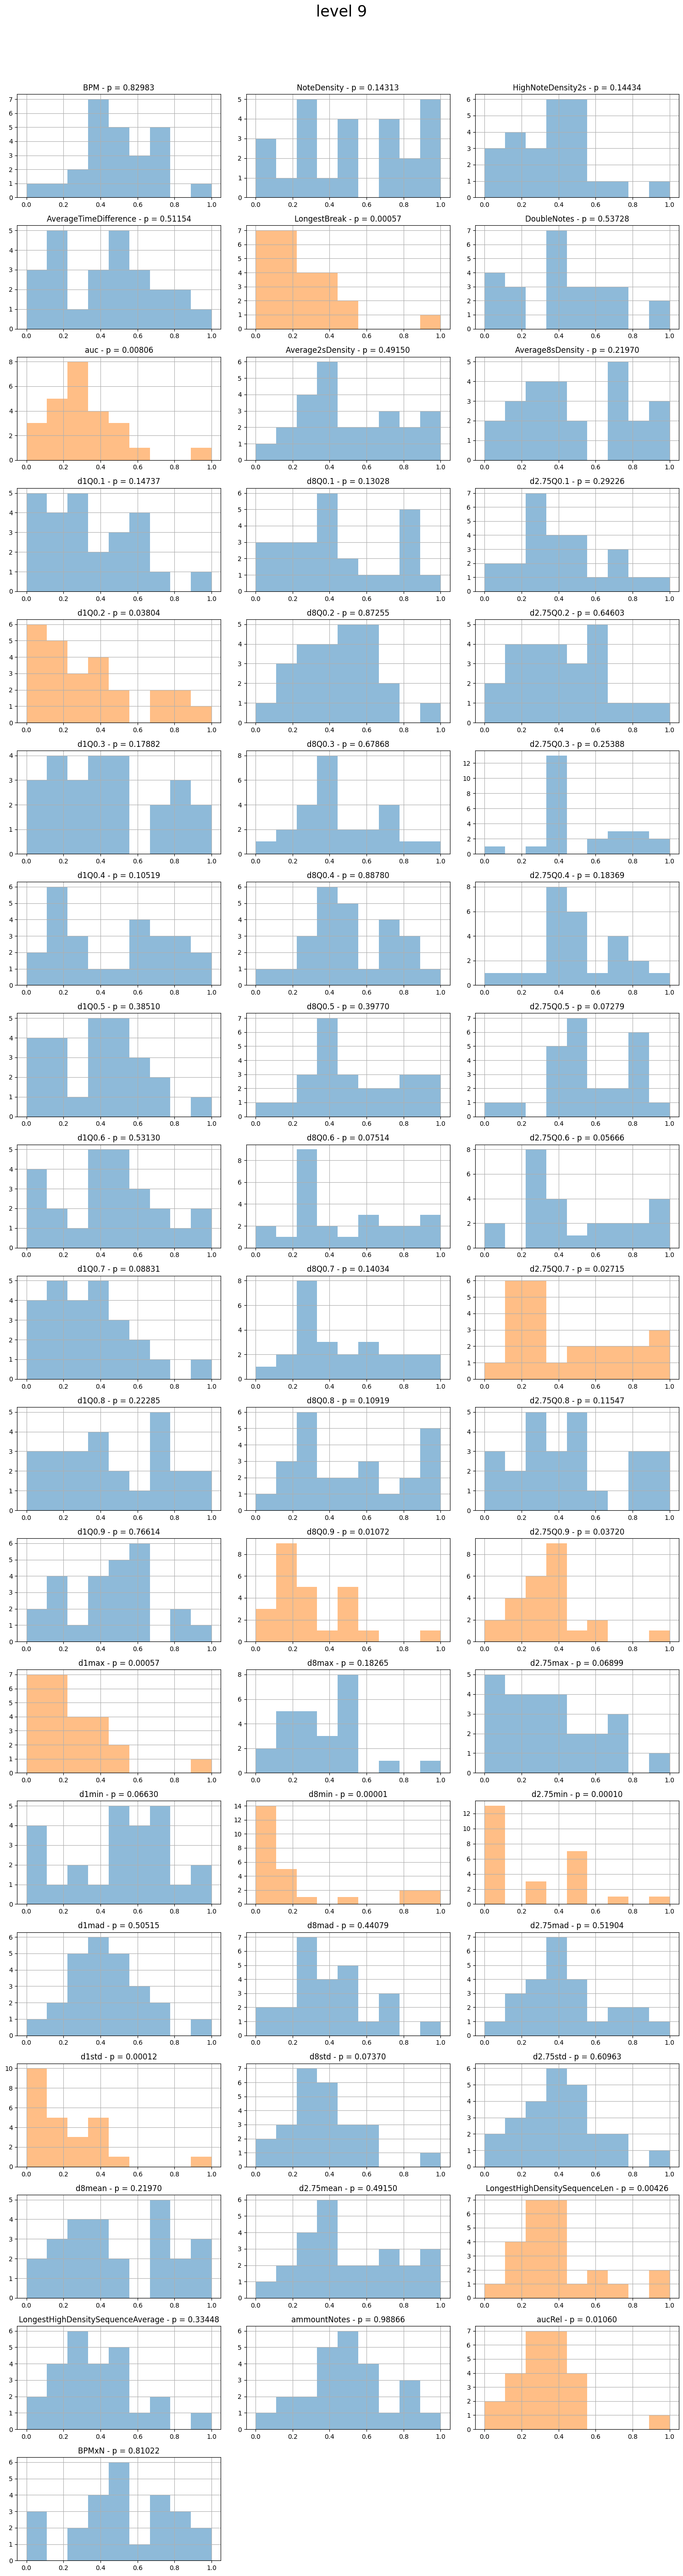

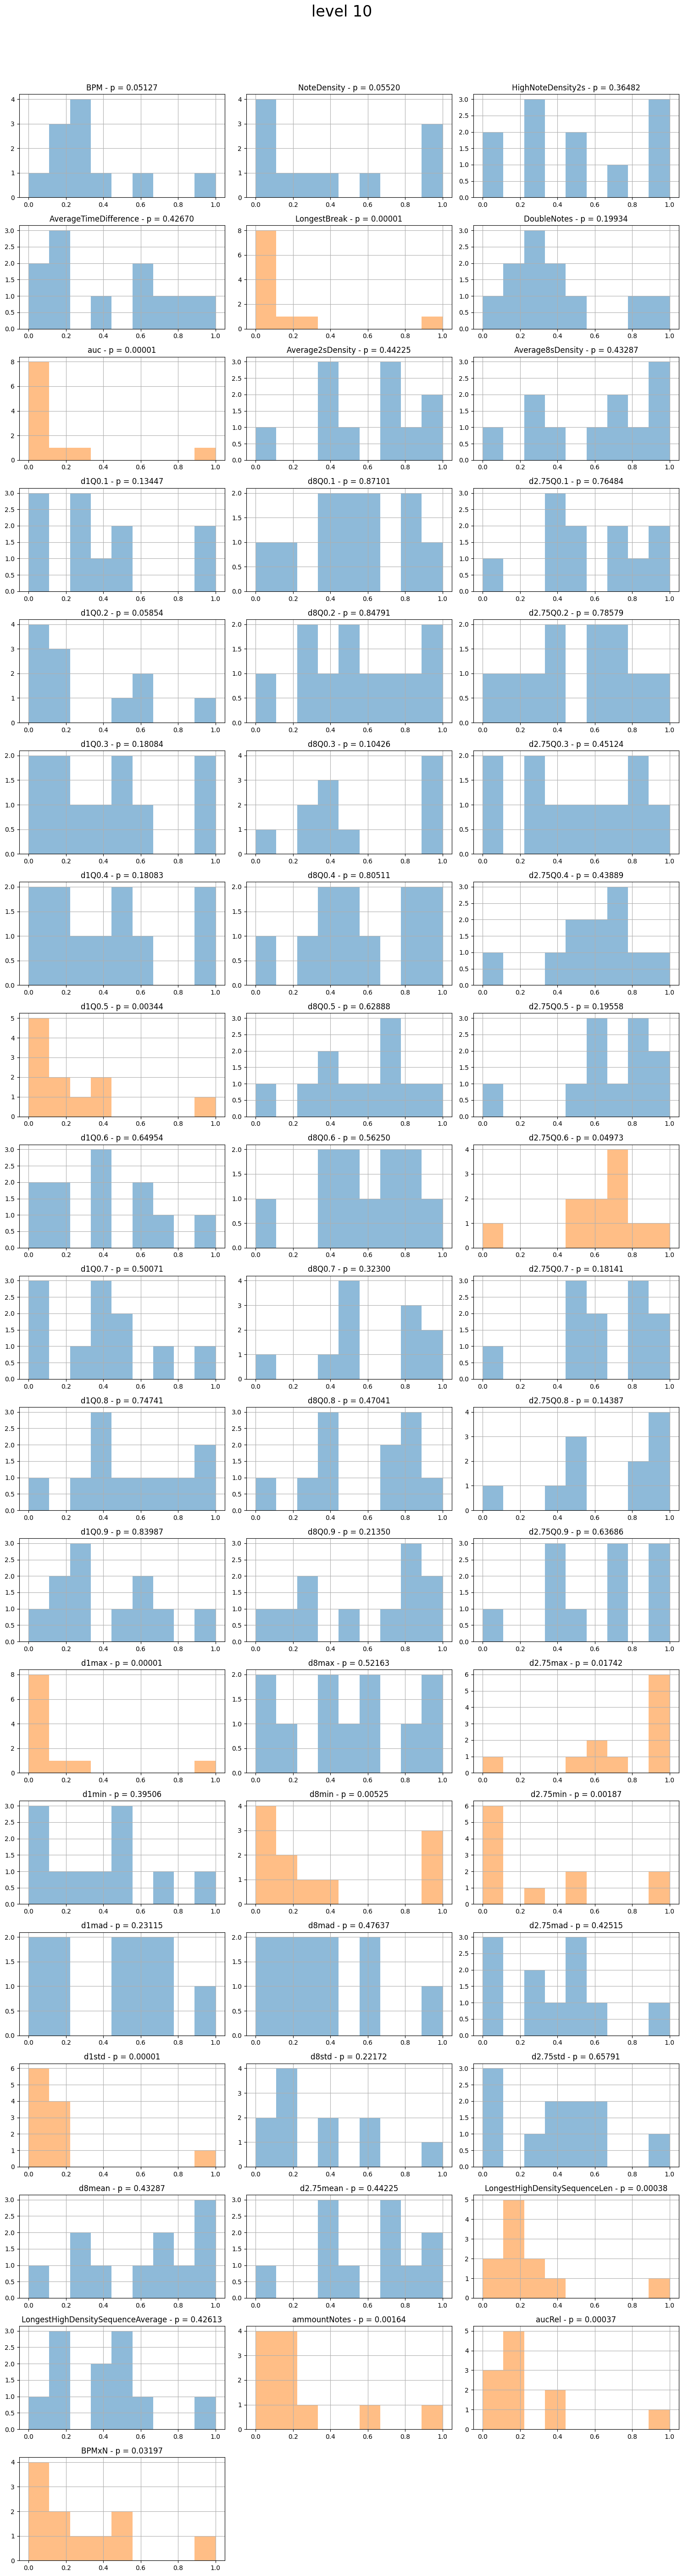

In [ ]:
# distribution
N = len(featureList)

for level in range(1, 11):
    plt.figure(figsize=(15, N))
    df_level = df.loc[df['Difficulty'] == level]
    for i, feature in enumerate(featureList):
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(df_level[[feature]])
        if np.ptp(X_scaled) == 0:
            continue
        _, p_shapiro = stats.shapiro(X_scaled)
        color = cm.tab10.colors[0]
        if p_shapiro < 0.05:
            color = cm.tab10.colors[1]
        plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i + 1)
        plt.hist(X_scaled, bins=9, alpha=0.5, color=color)
        plt.title(f"{featureList[i]} - p = {p_shapiro:.5f}")
        plt.grid(True)

    plt.suptitle(f"level {level}", y=1.02, fontsize=24)
    plt.tight_layout()
    plt.show()


In [ ]:
def convert_to_dict(input_list):
    result_dict = {}
    for value, type_name in input_list:
        if type_name in result_dict:
            result_dict[type_name] += (value,)
        else:
            result_dict[type_name] = (value,)
    return result_dict

def generate_test_list(df):
    for level in range(1, 11):
        df_level = df.loc[df['Difficulty'] == level]
        for feature in featureList:
            feature_values = df_level[feature].dropna()
            if feature_values.empty:
                continue
            if np.ptp(feature_values) == 0:
                continue
            _, p_shapiro = stats.shapiro(feature_values)
            if p_shapiro < 0.05:
                yield (level, feature)

convert_to_dict(list(generate_test_list(df)))

{'BPM': (1,),
 'd1Q0.1': (1, 2, 4, 5),
 'd8Q0.1': (1,),
 'd1Q0.2': (1, 4, 5, 8, 9),
 'd1Q0.3': (1, 4, 5, 8),
 'd1Q0.4': (1, 4),
 'd1Q0.5': (1, 6, 10),
 'd1Q0.6': (1, 7),
 'd2.75Q0.6': (1, 2, 3, 6, 8, 10),
 'd8Q0.7': (1, 6, 8),
 'd2.75Q0.7': (1, 2, 3, 4, 8, 9),
 'd1Q0.9': (1, 2, 3, 4, 5, 6),
 'd8min': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 'd8mad': (1, 3, 4, 8),
 'BPMxN': (1, 3, 4, 5, 7, 8, 10),
 'HighNoteDensity2s': (2,),
 'LongestBreak': (2, 3, 4, 5, 6, 7, 9, 10),
 'auc': (2, 3, 4, 5, 7, 8, 9, 10),
 'd2.75Q0.1': (2, 3, 4, 5, 8),
 'd2.75Q0.3': (2, 3, 8),
 'd2.75Q0.4': (2, 3, 4, 6, 8),
 'd2.75Q0.5': (2, 3, 8),
 'd1Q0.7': (2,),
 'd1Q0.8': (2, 4),
 'd8Q0.8': (2, 8),
 'd2.75Q0.8': (2, 7, 8),
 'd1max': (2, 3, 4, 5, 6, 7, 9, 10),
 'd8max': (2, 6, 7),
 'd1min': (2, 3, 5, 8),
 'd2.75min': (2, 3, 4, 5, 6, 7, 8, 9, 10),
 'd1mad': (2, 3, 4, 5, 6),
 'd1std': (2, 3, 5, 6, 7, 8, 9, 10),
 'd8std': (2, 8),
 'd2.75std': (2, 4, 6),
 'LongestHighDensitySequenceAverage': (2, 3, 4, 5, 7),
 'DoubleNotes': (3, 4,

## univariate

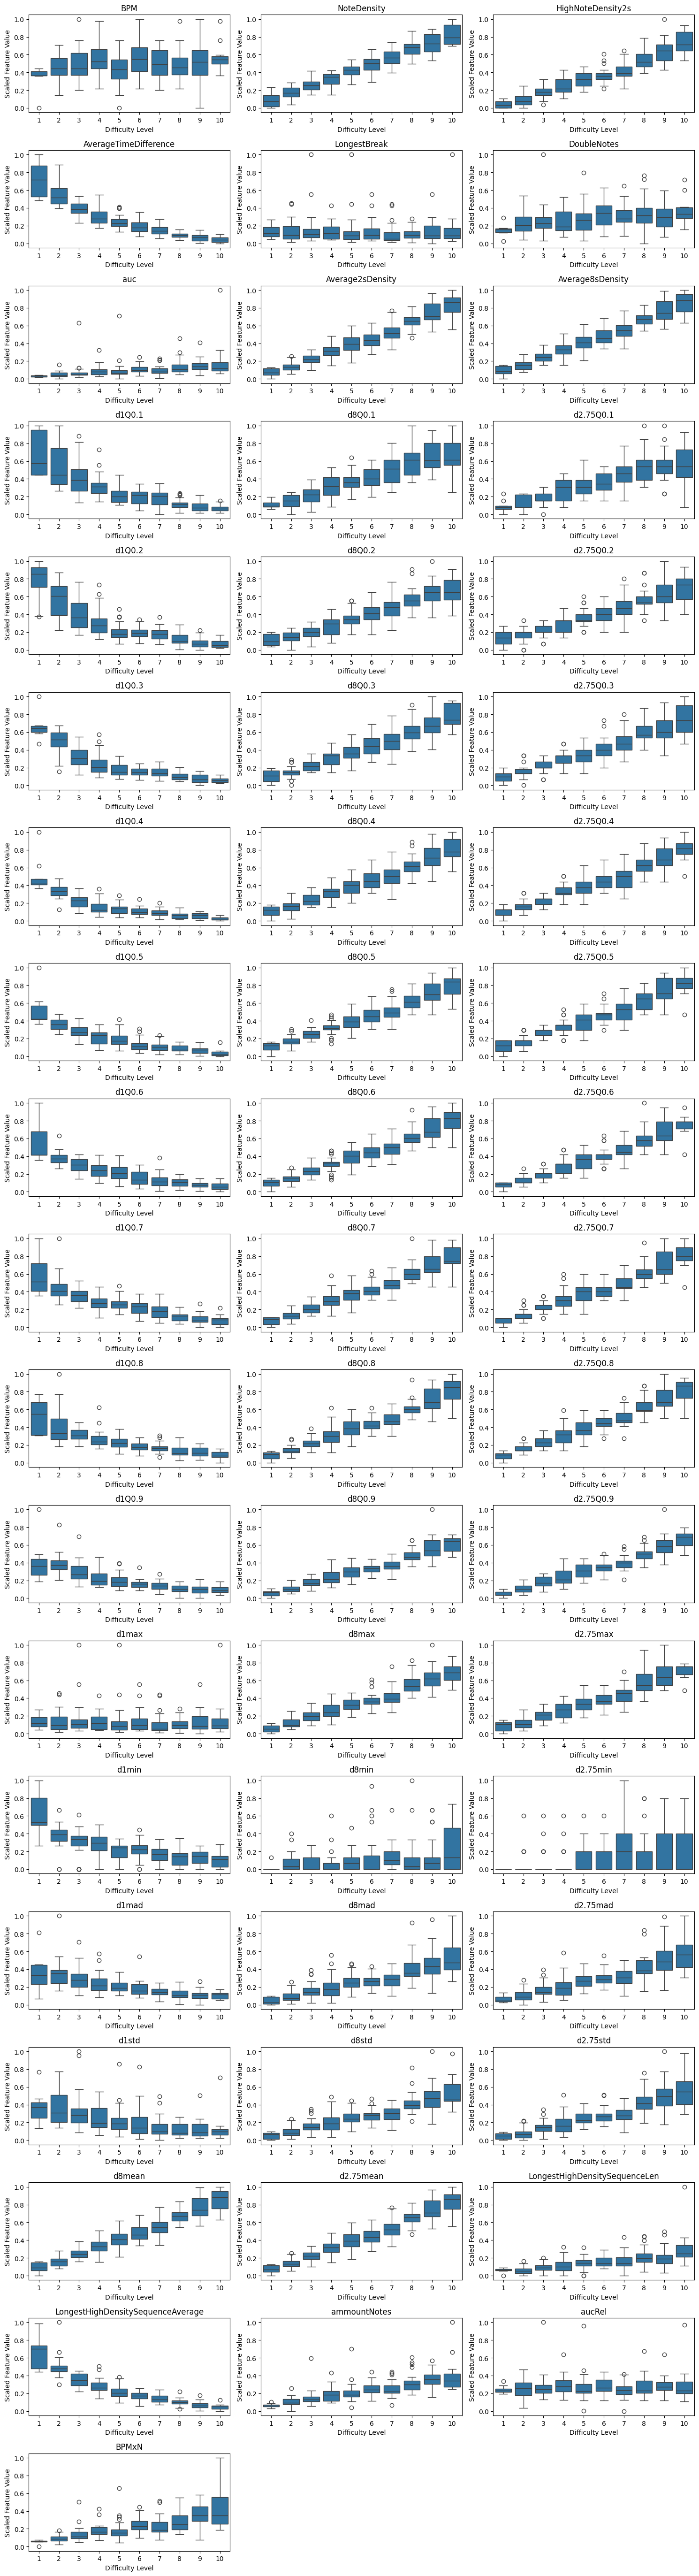

In [ ]:
N = len(featureList)
X = df[featureList]
y = df[targetFeature]

plt.figure(figsize=(15, N))
for i in range(N):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.iloc[:, i].values.reshape(-1, 1))

    sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
    plt.xlabel('Difficulty Level')
    plt.ylabel('Scaled Feature Value')
    plt.title(featureList[i])

plt.tight_layout()
plt.show()


this part is only used to generate plots individually:

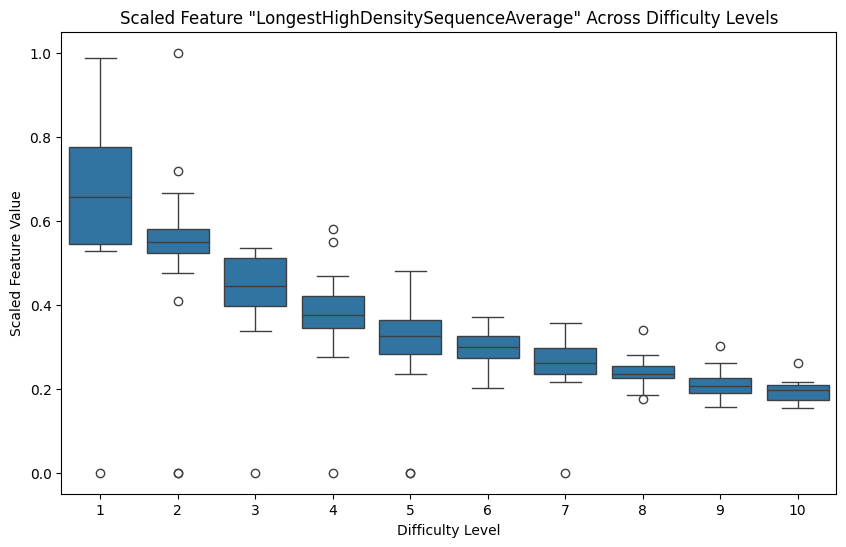

In [ ]:
feature_number = 51

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.iloc[:, feature_number].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
plt.xlabel('Difficulty Level')
plt.ylabel('Scaled Feature Value')
plt.title('Scaled Feature "' + featureList[feature_number] + '" Across Difficulty Levels')
plt.show()


## 3d model
this is a simple plot to visualize the relationship between 3 features

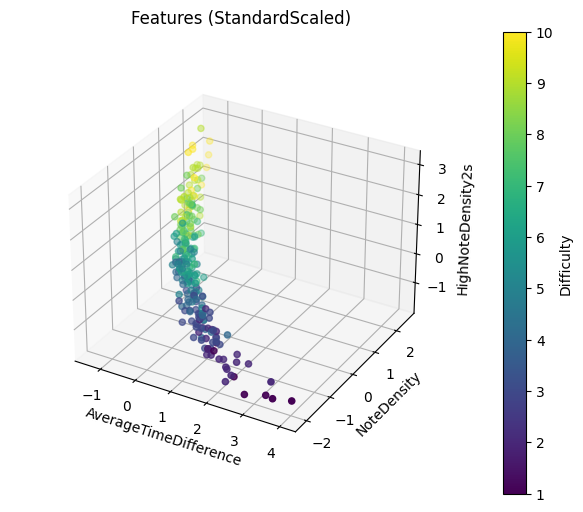

In [ ]:
X_dimensions = ["AverageTimeDifference", "NoteDensity", "HighNoteDensity2s"]
targetFeature = ["Difficulty"]
X = df[X_dimensions]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y.values, cmap='viridis')

ax.set_xlabel(X_dimensions[0])
ax.set_ylabel(X_dimensions[1])
ax.set_zlabel(X_dimensions[2])
ax.set_title('Features (StandardScaled)')

ax.set_box_aspect(None, zoom=0.85)

cbar = fig.colorbar(scatter, ax=ax, label='Difficulty')

plt.show()


## 2d

The interpretation is simple: we have a better classification if each group is close to each other in a narrow range and well delimited from other groups

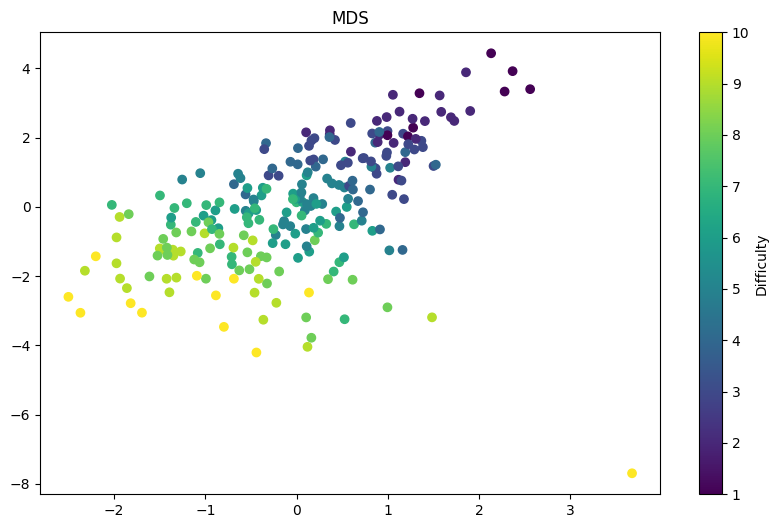

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = MDS(n_components=2, normalized_stress='auto')
transformed_data = model.fit_transform(X_scaled)

df['MDS_1'] = transformed_data[:, 0]
df['MDS_2'] = transformed_data[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['MDS_1'], df['MDS_2'], c=y.Difficulty, cmap='viridis')
plt.title('MDS')
plt.colorbar(label='Difficulty')
plt.show()


MDS: Optimized visualization of similarities or differences between data points in a low-dimensional space

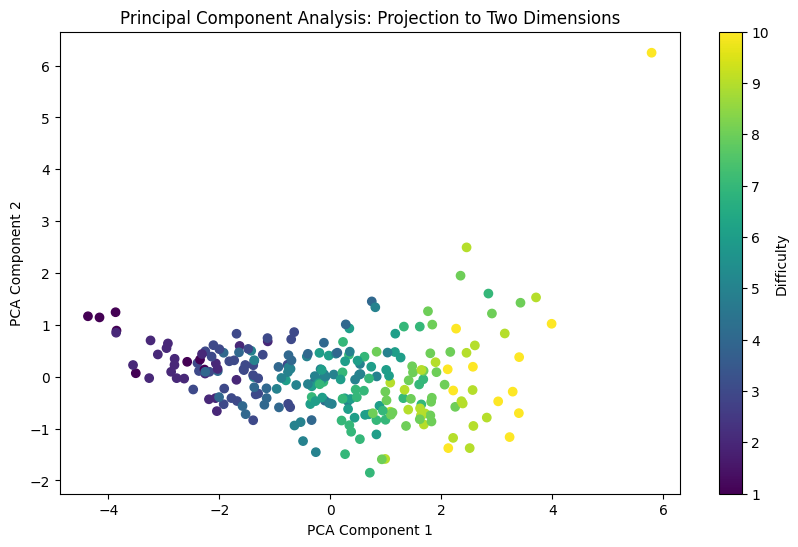

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component_1'] = X_pca[:, 0]
df['PCA_Component_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Principal Component Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
X_pca = df[['PCA_Component_1', 'PCA_Component_2']].values
detector = OneClassSVM(nu=0.01)
outlier_labels = detector.fit_predict(X_pca)
df['Outlier'] = outlier_labels
print(df[df['Outlier'] == -1][['SongName', 'Difficulty']])

                                SongName  Difficulty
27                                 Nitro           1
41                  The Land of Unicorns           9
98               The Great Pirate Bottle          10
102                    Call of the North           2
139                            Löwenherz           4
155                                Vodka           7
207  The Fires of Ancient Cosmic Destiny           3
227                         Loose Cannon           9
237                            Ambiramus           2
238                            Ambiramus           4


In [ ]:
df.loc[df['PCA_Component_2'].idxmax()][['SongName', 'Difficulty']]

SongName      The Fires of Ancient Cosmic Destiny
Difficulty                                     10
Name: 209, dtype: object

In LDA, the class information of the data is used to find an optimal linear discriminant that enables maximum separation between the classes. (better groups -> correlation in classdepenecy)

PCA: the class information is not relevant

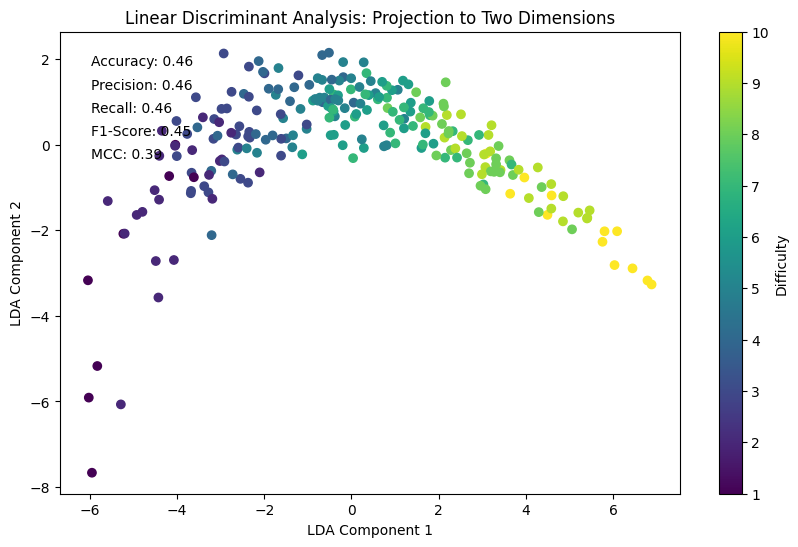

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component_1'] = X_lda[:, 0]
df['LDA_Component_2'] = X_lda[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('Linear Discriminant Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')

y_pred = lda.predict(X_scaled)
accuracy = lda.score(X_scaled, y_encoded)
precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)
plt.show()

In [ ]:
df.loc[df['LDA_Component_1'].idxmax()][['SongName', 'Difficulty']]

SongName      The Land of Unicorns
Difficulty                      10
Name: 41, dtype: object

In [ ]:
df.loc[df['Difficulty'] == 9].sort_values(by='LDA_Component_1')[['SongName', 'Difficulty']]

SongName  Difficulty
56                Universe on fire           9
26                     Evier metal           9
53                          Whaole           9
86                         Skyfall           9
68                 Mine Mine Mine!           9
236                Drunken dwarves           9
227                   Loose Cannon           9
218                 Randy Dandy Oh           9
131             One Night In Tokyo           9
29                           Nitro           9
170                  Stormtroopers           9
47                      Kampfzwerg           9
2                  Man the Cannons           9
215          Masters of The Galaxy           9
230               Steel Commanders           9
221              A Man With A Plan           9
50                         Iridium           9
224  Life Will Always Find Its Way           9
113                     Revolution           9
164                  Abyss Of Time           9
107           No Grave But The Sea           9
200      Rise of the Chaos Wizards           9
203           The Siege of Dunkeld           9
11                           Niemi           9

In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['sMaxInfluence'] = feature_weighting[X.columns].apply(second_max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  HighNoteDensity2s  \
1     -0.467279              12.156122          -3.232426   
2     -3.056297               5.187200          -3.593360   
3     -4.775334              -0.209647          -3.206505   
4     -4.707476              -2.310880          -2.179830   
5     -2.931875              -2.854068          -1.174139   
6     -0.723972              -2.457544          -0.298916   
7      1.497521              -1.915430           0.355066   
8      4.675173              -0.279015           2.940795   
9      6.488300               1.060341           5.613072   
10    11.229305               4.449407           7.049934   

    LongestHighDensitySequenceLen           MaxInfluence  \
1                        0.048686  AverageTimeDifference   
2                       -0.333484  AverageTimeDifference   
3                       -0.201722            NoteDensity   
4                       -0.187437            NoteDensity   
5                       -0.119907            NoteDensity   
6                        0.009445  AverageTimeDifference   
7                       -0.086481  AverageTimeDifference   
8                        0.390501            NoteDensity   
9                       -0.087113            NoteDensity   
10                       1.405471            NoteDensity   

            sMaxInfluence                   MinInfluence  
1       HighNoteDensity2s  LongestHighDensitySequenceLen  
2       HighNoteDensity2s  LongestHighDensitySequenceLen  
3       HighNoteDensity2s  LongestHighDensitySequenceLen  
4   AverageTimeDifference  LongestHighDensitySequenceLen  
5   AverageTimeDifference  LongestHighDensitySequenceLen  
6             NoteDensity  LongestHighDensitySequenceLen  
7             NoteDensity  LongestHighDensitySequenceLen  
8       HighNoteDensity2s          AverageTimeDifference  
9       HighNoteDensity2s  LongestHighDensitySequenceLen  
10      HighNoteDensity2s  LongestHighDensitySequenceLen

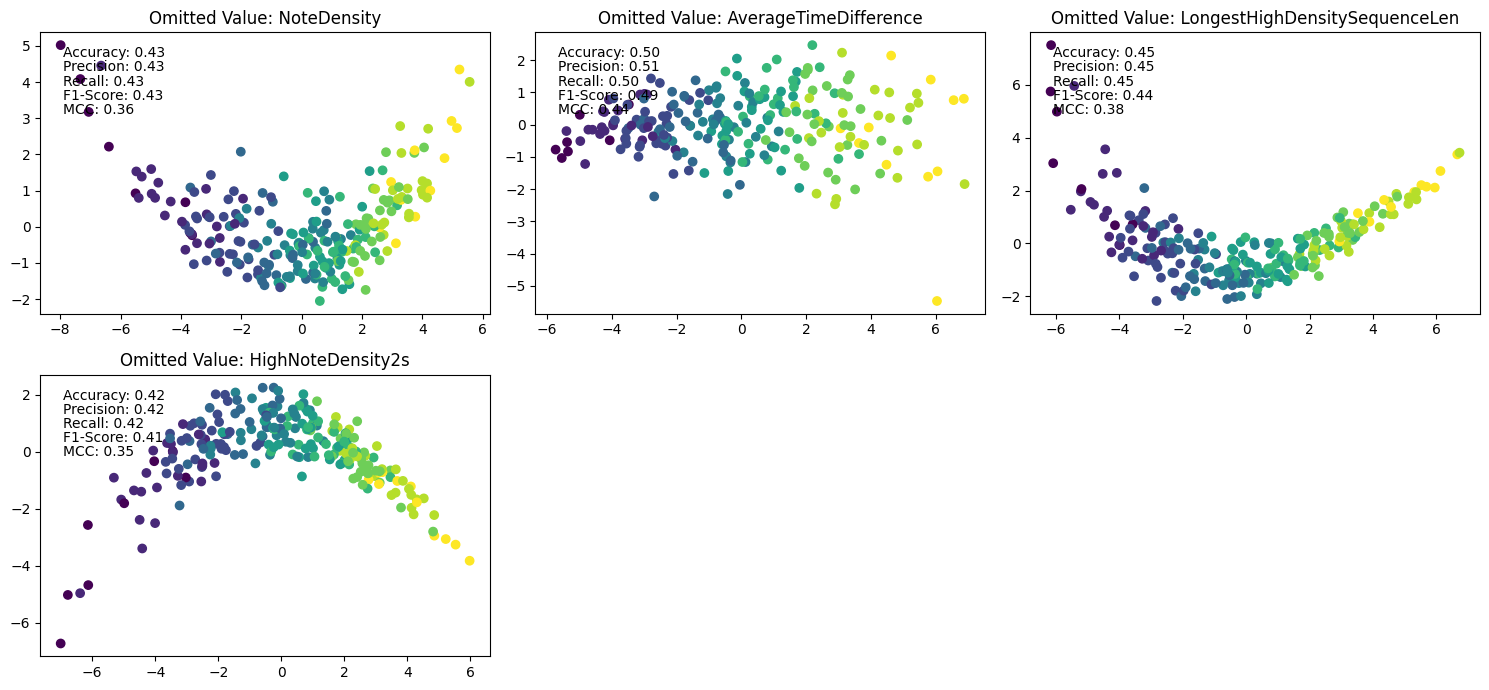

In [15]:
featureList = x_test_dims
y = df[targetFeature]
N = len(featureList)
plt.figure(figsize=(15, N * 1.75))

for i, (features, omitted_value) in enumerate(generate_leave_one_value_out_sequence(featureList)):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)
    X = df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y.values.ravel())

    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_encoded)

    df['LDA_Component_1'] = X_lda[:, 0]
    df['LDA_Component_2'] = X_lda[:, 1]

    plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')

    plt.title(f'Omitted Value: {omitted_value}')

    y_pred = lda.predict(X_scaled)

    accuracy = lda.score(X_scaled, y_encoded)
    precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
    recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
    f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
    MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

    settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
    plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
    plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
    plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
    plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
    plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)

plt.tight_layout()
plt.show()

## 1d

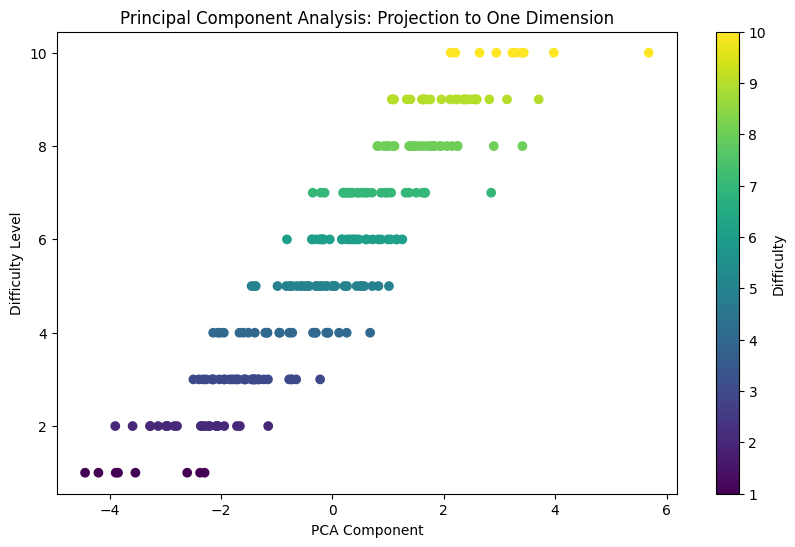

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component'] = X_pca.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(X_pca, y, c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component')
plt.ylabel('Difficulty Level')
plt.title('Principal Component Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()

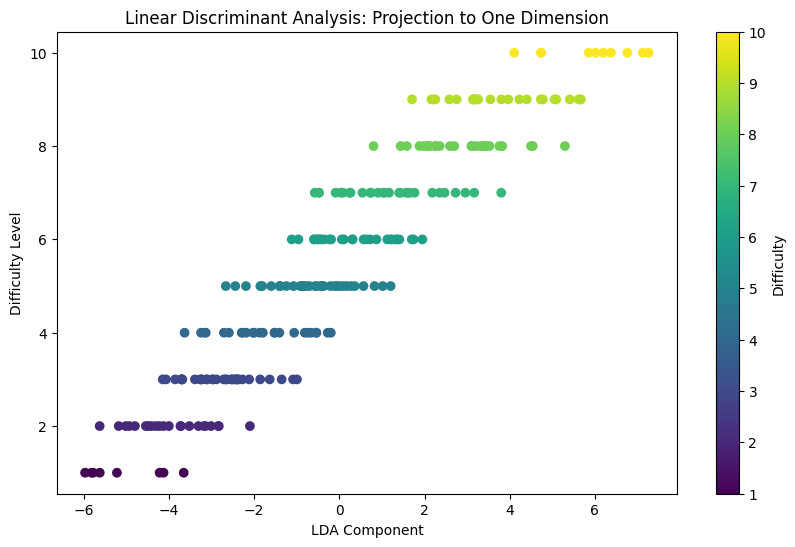

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component'] = X_lda.squeeze()

X_lda = df['LDA_Component']
y_lda = df[targetFeature]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda, y_lda, c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component')
plt.ylabel('Difficulty Level')
plt.title('Linear Discriminant Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()


In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  LongestHighDensitySequence  \
1     -1.016289              11.634746                    0.017177   
2     -3.855977               4.424541                   -0.417057   
3     -5.427641              -0.877173                   -0.262211   
4     -5.184972              -2.839148                   -0.215200   
5     -3.201797              -3.239731                   -0.112445   
6     -0.646109              -2.376118                   -0.001524   
7      1.638745              -1.785730                   -0.073168   
8      5.317967               0.426716                    0.422105   
9      7.190487               1.816681                    0.161498   
10    13.852302               7.092949                    1.263975   

    HighNoteDensity2s           MaxInfluence                MinInfluence  
1           -3.612693  AverageTimeDifference  LongestHighDensitySequence  
2           -3.887464  AverageTimeDifference  LongestHighDensitySequence  
3           -3.737597            NoteDensity  LongestHighDensitySequence  
4           -2.727902            NoteDensity  LongestHighDensitySequence  
5           -1.695927  AverageTimeDifference  LongestHighDensitySequence  
6           -0.411708  AverageTimeDifference  LongestHighDensitySequence  
7            0.483994  AverageTimeDifference  LongestHighDensitySequence  
8            3.585439            NoteDensity  LongestHighDensitySequence  
9            5.968914            NoteDensity  LongestHighDensitySequence  
10          10.159364            NoteDensity  LongestHighDensitySequence

# Model

In [18]:
df.loc[41]

SongName                 The Fires of Ancient Cosmic Destiny
BPM                                                      170
NoteDensity                                         5.886658
HighNoteDensity2s                                  11.636364
AverageTimeDifference                               0.194029
                                        ...                 
ammountNotes                                            3623
aucRel                                            320.920555
BPMxN                                                 545190
LDA_Component_1                                      4.85341
LDA_Component_2                                    -2.940715
Name: 41, Length: 64, dtype: object

In [19]:
# Here you have the option to reclassify strong outliers.
df.loc[41, 'Difficulty'] = 10
df.loc[53, 'Difficulty'] = 9


## Curr. SVR

In [ ]:
featureList = ["BPM", 'NoteDensity', 'HighNoteDensity2s']

X = df[featureList].values
y = df[targetFeature]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test = X, X, y, y # cross validation is sufficient here

param_grid = {'C': np.linspace(0.01, 100, num=1000)}

# # params by PKBeam
# svm = SVR(epsilon=0.5, C=33.74)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=5))
])

pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=5, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02])}))])

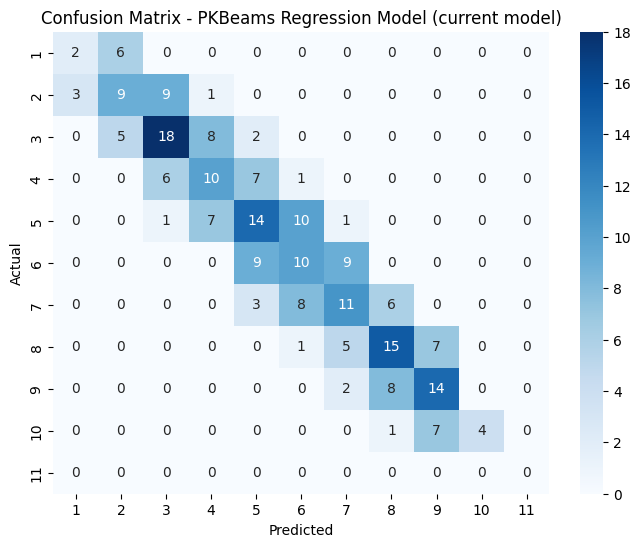

Accuracy     0.445833
Precision    0.463895
Recall       0.445833
F1           0.445295
MCC          0.374955
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

# classes = np.sort(y.Difficulty.unique())
classes = range(1, 12)
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - PKBeams Regression Model (current model)', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

## LDA 4Dim, SVR

In [20]:
featureList = ["NoteDensity", "AverageTimeDifference", "LongestHighDensitySequenceLen", "HighNoteDensity2s"]

X = df[featureList].values
y = df[targetFeature].values.ravel()

param_grid = {'C': np.logspace(-2, 2, num=1000)}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(n_components=4)),
    # ('pca', PCA(n_components=4)),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=10))
], verbose=True)

pipeline.fit(X, y)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lda, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 1.1min


Pipeline(steps=[('scaler', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis(n_components=4)),
                ('classifier',
                 GridSearchCV(cv=10, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02])}))],
         verbose=True)

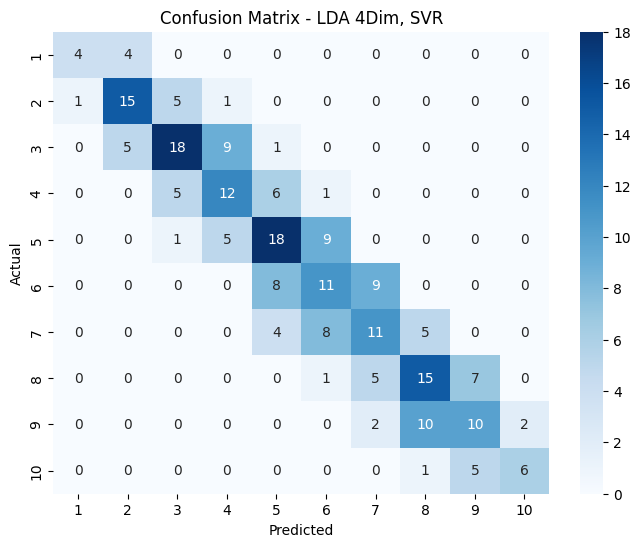

Accuracy     0.500000
Precision    0.510354
Recall       0.500000
F1           0.501627
MCC          0.436976
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

# classes = np.sort(y.Difficulty.unique())
classes = range(1, 11)
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - LDA 4Dim, SVR', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

# Export

In [ ]:
from sklearn2pmml import PMMLPipeline, sklearn2pmml

pmml_pipeline = PMMLPipeline(pipeline.steps)
pmml_pipeline.fit(X, y)

print(pmml_pipeline)

sklearn2pmml(pmml_pipeline, "model.pmml")

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

input_type = [('input', FloatTensorType([None, len(featureList)]))]

onnx_model = convert_sklearn(pipeline, 'model.onnx', initial_types=input_type)

with open("./model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

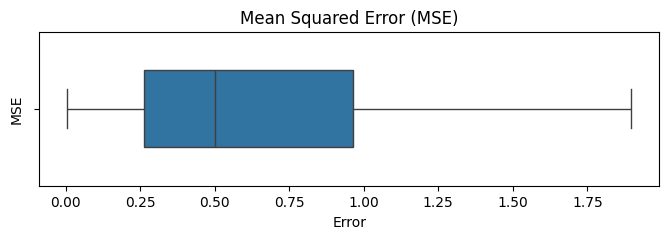

actual  predicted     error
198       3   4.896520  1.896520
28        5   3.120402  1.879598
56        9   7.159472  1.840528
49        7   5.177969  1.822031
5         8   6.219867  1.780133
..      ...        ...       ...
126       3   2.983205  0.016795
195       1   1.015640  0.015640
159       4   3.985873  0.014127
166       6   5.987521  0.012479
108       2   1.993605  0.006395

[240 rows x 3 columns]

In [ ]:
#test model
import onnxruntime as rt
sess = rt.InferenceSession("./model.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})[0]

predicted_labels = [float(label) for label in pred_onx]
errors = np.abs(y_test - predicted_labels)
df_model_result = pd.DataFrame({"actual": y_test, "predicted": predicted_labels, "error": errors})
df_model_result = df_model_result.sort_values(by="error", ascending=False)

plt.figure(figsize=(8, 2))
sns.boxplot(x='error', data=df_model_result, width=0.5)
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Error')
plt.ylabel('MSE')
plt.show()

df_model_result

In [ ]:
df[featureList].min()

NoteDensity                      1.627074
AverageTimeDifference            0.152743
HighNoteDensity2s                2.181818
LongestHighDensitySequenceLen    0.000000
dtype: float64

In [ ]:
df[featureList].max()